# 00 IMPORTS

In [1]:
import warnings

import bisect
import inflection
import joblib            as jb
import numpy             as np
import pandas            as pd

from scipy import stats  as ss

import seaborn           as sns
import matplotlib.pyplot as plt

from IPython.display         import Image
from IPython.core.display    import HTML

# data balancing
from imblearn.combine        import SMOTETomek
# feature selection
from boruta                  import BorutaPy
# Hyperparameter Fine Tuning
from skopt                   import forest_minimize
# Models
from xgboost                 import XGBClassifier
from lightgbm                import LGBMClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression

from sklearn.metrics         import roc_auc_score, average_precision_score, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.preprocessing   import RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

## 0.1 Load Dataset

In [2]:
dfRaw = pd.read_csv('../../01-Data/churn.csv')

In [3]:
dfRaw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### 0.1.1 Saving Test Dataset

In [5]:
X = dfRaw.drop(columns=['Exited'], axis=1)
Y = dfRaw['Exited']

# spliting into train and test dataset
x, X_test, y, y_test = train_test_split(X, Y, test_size=0.1, random_state=42, stratify=Y)
test_dataset = pd.concat([X_test, y_test], axis=1).reset_index()
test_dataset.to_feather('00-Data/FeatherData/test_dataset.feather')

# train
train_dataset = pd.concat([x, y], axis=1).reset_index()

## 0.2 Helper Functions

### 0.2.1 Jupyter Config

In [6]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    seed = 0
    np.random.seed(seed)
    
    warnings.filterwarnings("ignore")
    
    sns.set()

In [7]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


### 0.2.1 Functions

In [8]:
def group_age(num, breakpoints=[10, 20, 30, 45, 60, 70, 80, 120], result='01234567'):
    i = bisect.bisect(breakpoints, num-1)
    age_mapping = {
        0: 'Child',
        1: 'Teenager',
        2: 'Young',
        3: 'Adult',
        4: 'Midlife',
        5: 'Senior',
        6: 'Mature Adulthood',
        7: 'Late Adulthood'
    }
    return age_mapping[i]



def cramerV(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))



def ml_scores(model_name, y, yhat, yhat_proba):
    precision = precision_score(y, yhat)
    recall = recall_score(y, yhat)
    f1 = f1_score(y, yhat)
    kappa = cohen_kappa_score(y, yhat)
    ap = average_precision_score(y, yhat_proba)
    roc_auc = roc_auc_score(y, yhat_proba)
    
    return pd.DataFrame({ 'Model Name': model_name, 
                           'Precision': precision, 
                           'Recall': recall,
                           'F1 Score': f1,
                           'Kappa': kappa,
                           'Average Precision Score': ap,
                           'ROC AUC': roc_auc}, index=[0])



def cross_validation(X_training, kfold, model_name, model, verbose=False):
    precision_list = []
    recall_list = []
    f1_list = []
    kappa_list = []
    ap_list = []
    roc_auc_list = []
    X_training = X_training.sample(frac=1).reset_index(drop=True)
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print(f'\nKFold Number: {k}')
        # Filtering Dataset
        training = X_training.iloc[0: k*(round(X_training.shape[0]/(kfold+1))), :]
        validation = X_training.iloc[k*(round(X_training.shape[0]/(kfold+1))) : (k+1)*(round(X_training.shape[0]/(kfold+1))), :]

        # Training and Validation Dataset
        # Training
        X_kfold_training = training.drop(['exited'], axis=1)
        y_kfold_training = training['exited']

        # Validation
        X_kfold_validation = validation.drop(['exited'], axis=1)
        y_kfold_validation = validation['exited']
        
        #Model
        model.fit(X_kfold_training, y_kfold_training)

        # Prediction
        yhat = model.predict(X_kfold_validation)
        
        # Prediction Proba
        yhat_proba = model.predict_proba(X_kfold_validation)[:,1]

        #Performance
        model_result = ml_scores(model_name, y_kfold_validation, yhat, yhat_proba)
        
        #Store Performance of each KFold iteration
        precision_list.append(model_result['Precision'].tolist())
        recall_list.append(model_result['Recall'].tolist())
        f1_list.append(model_result['F1 Score'].tolist())
        kappa_list.append(model_result['Kappa'].tolist())
        ap_list.append(model_result['Average Precision Score'].tolist())
        roc_auc_list.append(model_result['ROC AUC'].tolist())
    

    dict_result = {
                    'Model Name': [model_name],
                    'Precision CV': [np.round(np.mean(precision_list),4).astype(str) + ' +/- ' + np.round(np.std(precision_list),4).astype(str)],
                    'Recall CV': [np.round(np.mean(recall_list),4).astype(str) + ' +/- ' + np.round(np.std(recall_list),4).astype(str)],
                    'F1 Score CV': [np.round(np.mean(f1_list),4).astype(str) + ' +/- ' + np.round(np.std(f1_list),4).astype(str)],
                    'Kappa CV': [np.round(np.mean(kappa_list),4).astype(str) + ' +/- ' + np.round(np.std(kappa_list),4).astype(str)],
                    'Average Precision Score CV': [np.round(np.mean(ap_list),4).astype(str) + ' +/- ' + np.round(np.std(ap_list),4).astype(str)],
                    'ROC AUC CV': [np.round(np.mean(roc_auc_list),4).astype(str) + ' +/- ' + np.round(np.std(roc_auc_list),4).astype(str)]
                }

    return pd.DataFrame(dict_result)

# 1.0 DESCRIPTION

In [9]:
df01 = train_dataset.copy()

## 1.1 Columns

In [10]:
df01.columns

Index(['index', 'RowNumber', 'CustomerId', 'Surname', 'CreditScore',
       'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

### 1.1.1 Rename Columns

In [11]:
snakecase = lambda col: inflection.underscore(col)

new_columns = list(map(snakecase, df01.columns))

# rename
df01.columns = new_columns

#### 1.1.1.1 New Name Columns

In [12]:
df01.columns

Index(['index', 'row_number', 'customer_id', 'surname', 'credit_score',
       'geography', 'gender', 'age', 'tenure', 'balance', 'num_of_products',
       'has_cr_card', 'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

## 1.2 Data Dimensions

In [13]:
print(f'Number of Rows: {df01.shape[0]}')
print(f'Number of Columns: {df01.shape[1]}')

Number of Rows: 9000
Number of Columns: 15


## 1.3 Data Types

In [14]:
df01.dtypes

index                 int64
row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

### 1.3.1 Change Types

In [15]:
## Convert Objects type to categorical types >> more performatic
df01[df01.select_dtypes(include=['object']).columns] = df01.select_dtypes(include=['object']).astype('category')

## Convert Boolean integer columns to Boolean
df01[['has_cr_card', 'is_active_member', 'exited']] = df01[['has_cr_card', 'is_active_member', 'exited']].astype('bool')

In [16]:
df01.dtypes

index                  int64
row_number             int64
customer_id            int64
surname             category
credit_score           int64
geography           category
gender              category
age                    int64
tenure                 int64
balance              float64
num_of_products        int64
has_cr_card             bool
is_active_member        bool
estimated_salary     float64
exited                  bool
dtype: object

## 1.4 Not a Number

### 1.4.1 Sum NA

In [17]:
df01.isnull().sum()

index               0
row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

### 1.4.2 ~~Fillout NA~~

there is no NA values

## 1.5 Descriptive Statistical

In [18]:
# Numerical Attributes
num_attributes = df01.select_dtypes(include=['int64', 'float64'])
not_numerial = ['row_number', 'customer_id']
num_attributes = num_attributes[num_attributes.columns[~num_attributes.columns.isin(not_numerial)]]

#Categorical Attributes
cat_attributes = df01.select_dtypes(include=['category'])

#Boolean Attributes
bool_attributes = df01.select_dtypes(include=['bool'])

### 1.5.1 Numerical Attributes

In [19]:
### Central Tendency -> Mean, Median, Mode
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
ct3 = pd.DataFrame(ss.mode(num_attributes)[0])
ct3.columns = ct1.columns

### Dispersion -> std, min, max, range, skew, kurtosis, rsd
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
d7 = d1 / ct1



# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2,ct3, d1, d7, d5, d6]).T.reset_index()
m.columns = ['Attributes', 'Min', 'Max', 'Range', 'Mean', 'Median', 'Mode', 'Std','Relative Std', 'Skew', 'Kurtosis']
m

,Attributes,Min,Max,Range,Mean,Median,Mode,Std,Relative Std,Skew,Kurtosis
0,index,0.00,9999.00,9999.00,4993.198111,4996.500,0.00,2889.476826,0.578683,0.000566,-1.204558
1,credit_score,350.00,850.00,500.00,650.805444,652.000,850.00,96.634678,0.148485,-0.078800,-0.424522
2,age,18.00,92.00,74.00,38.930333,37.000,35.00,10.494037,0.269559,1.024857,1.429473
3,tenure,0.00,10.00,10.00,5.020667,5.000,2.00,2.892100,0.576039,0.009788,-1.168154
4,balance,0.00,238387.56,238387.56,76472.054947,97262.675,0.00,62349.182948,0.815320,-0.143684,-1.493040
5,num_of_products,1.00,4.00,3.00,1.528556,1.000,1.00,0.581823,0.380636,0.758916,0.635049
6,estimated_salary,11.58,199992.48,199980.90,99552.115873,99387.815,24924.92,57391.691502,0.576499,0.009628,-1.176062


#### 1.5.1.1 Numerical Attributes

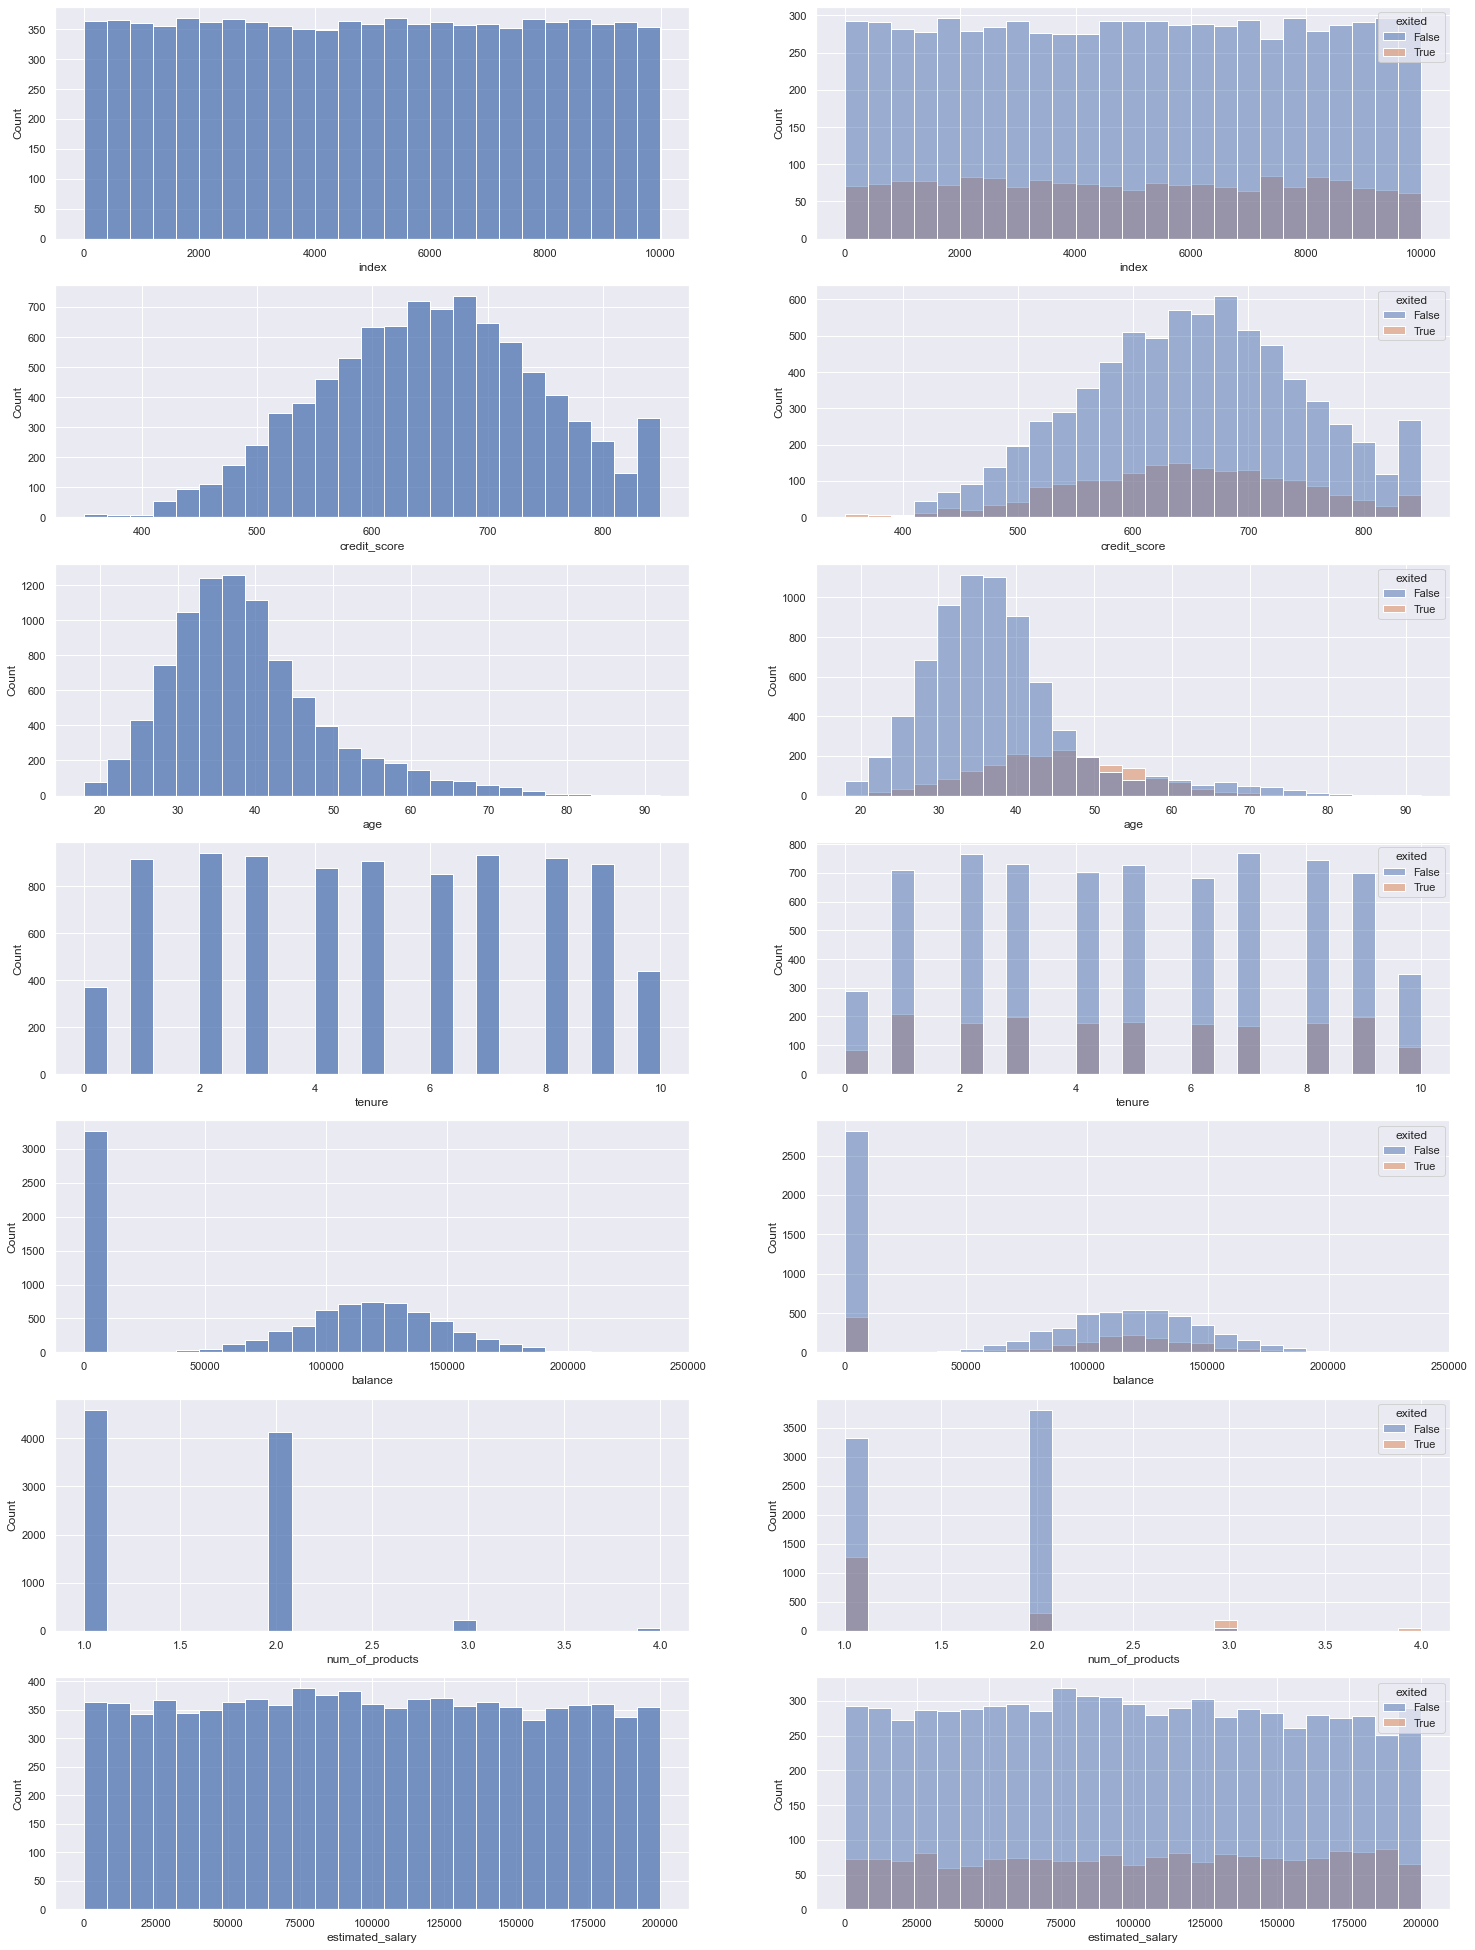

In [20]:
count = 1
attributes_to_inspect = m['Attributes'].tolist()
rows= len(attributes_to_inspect)
plt.figure(figsize=(25,5*rows))
for i in attributes_to_inspect:
    plt.subplot(rows, 2, count)
    sns.histplot(x=i, bins=25, data=df01)
    count += 1
    
    plt.subplot(rows, 2, count)
    sns.histplot(x=i, bins=25, hue='exited', data=df01)
    count += 1
plt.show()

#### 1.5.1.2 Some considerations
---
> **CreditScore**
>> - Although it has a high std, it has a relative low std which shows a small degree of dispersion
>> - Both Skew and low kurtosis show that the distribution is close to a normal curve
>> - However close the average and median are, the mode is consiversibly greater and evidences the asymmetry of the distribution
>
> **Age**
>> - The age range is large and it will be interesting to group by bands
>> - According to indices considered to be higher than 0, this distribution does not approach a normal distribution
>
> **Tenure**
>> - According to the relative std the distribution presents a great degree of dispersion
>
> **Balance**
>> - According to the relative std the distribution presents a great degree of dispersion
>> - It's noted the pressure of considered amount of outliers that make the average is lower than the median and that the mode is 0.00, which impacts a lot both the kurtosis and std
>
> **NumOfProducts**
>> - As this attribute is of the whole nature and by the media, median and fashion indices show an unbalanced distribution according to the range
>
> **EstimatedSalary**
>> - As the distribution has a very high std and a relative std as well, it can be noted that it is a distribution with great dispersion

### 1.5.2 Categorical Attributes

In [21]:
cat_attributes.apply(lambda x: x.unique().shape[0])

surname      2784
geography       3
gender          2
dtype: int64

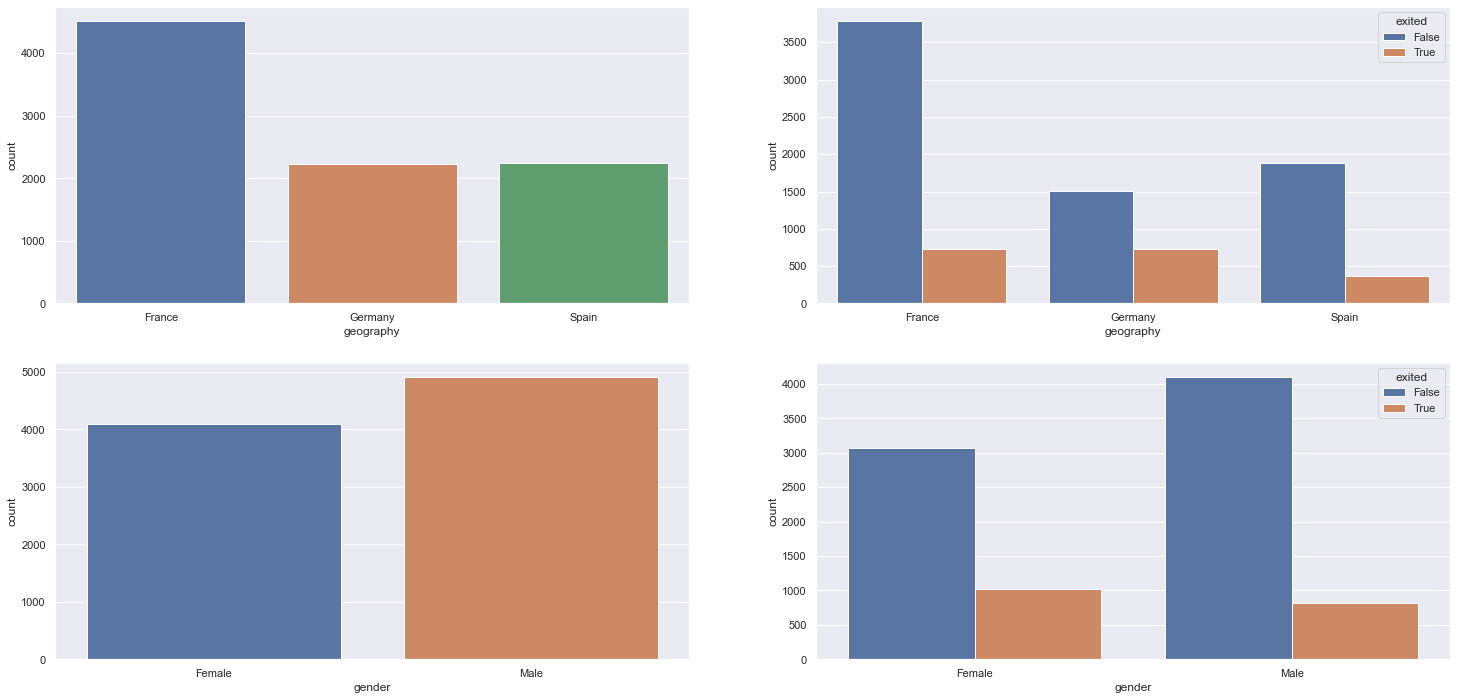

In [22]:
count = 1
attributes_to_inspect = ['geography', 'gender']
rows= len(attributes_to_inspect)
for i in attributes_to_inspect:
    plt.subplot(rows, 2, count)
    sns.countplot(x=i, data=df01)
    count += 1
    
    plt.subplot(rows, 2, count)
    sns.countplot(x=i, hue='exited', data=df01)
    count += 1
plt.show()

### 1.5.3 Boolean Attributes

In [23]:
df_bool = pd.DataFrame(bool_attributes.apply(lambda x: x.sum())).rename(columns={0:"Yes"})
df_bool['No'] = df_bool['Yes'].apply(lambda row: df01.shape[0] - row)
df_bool.head()

,Yes,No
has_cr_card,6362,2638
is_active_member,4626,4374
exited,1833,7167


# 2.0 FEATURE ENGINEERING

In [24]:
df02 = df01.copy()

## 2.1 Mind Map

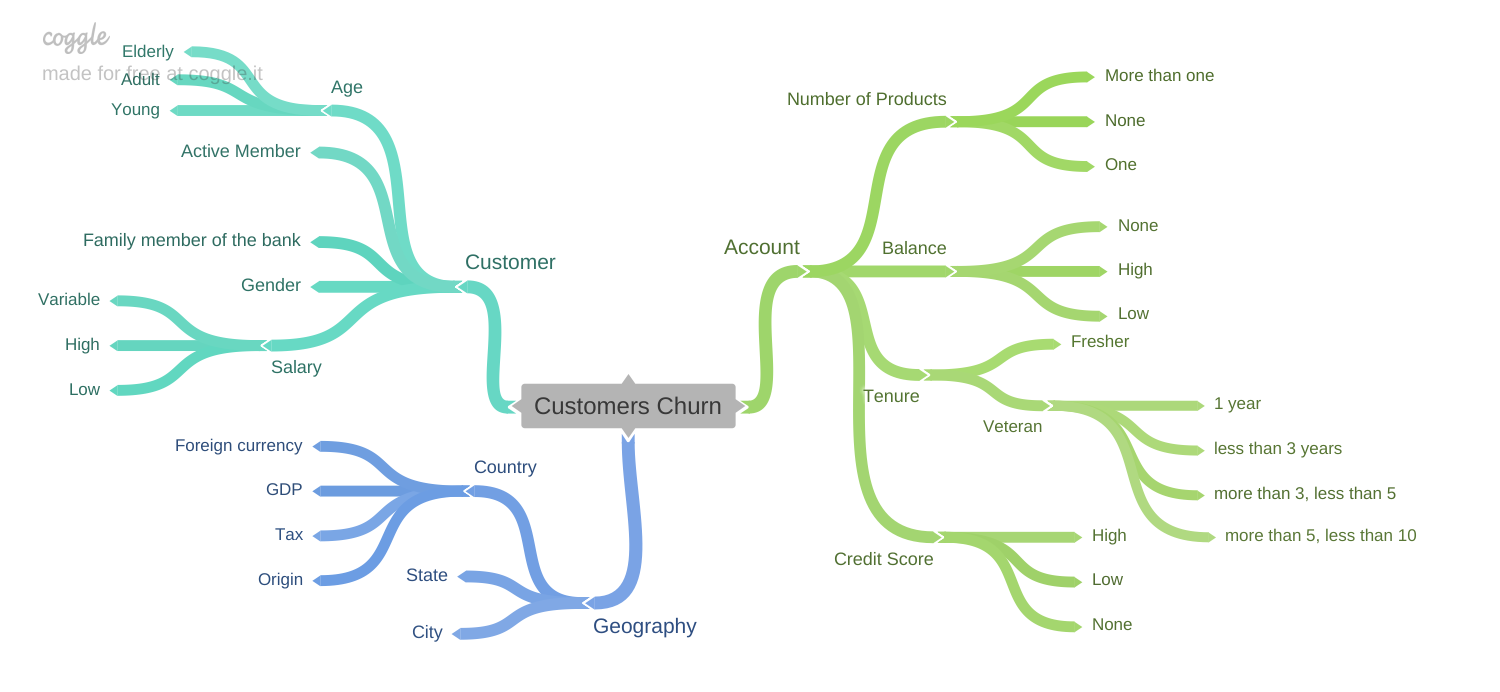

In [25]:
Image('../../img/01-FirstCycleCRISPCostumerChurn.png')

### 2.1.1 Formulation of Hypothesis

---
> **Customer**
>> - H01 - Clients with churn tend to be influenced by family members
>> - H02 - Men usually have more churn
>> - H03 - Women usually buy more products
>> - H04 - Younger clients are less loyal and more likely to leave a bank
>> - H05 - Older customers are less likely to leave their bank than younger ones
>> - H06 - Clients with higher estimated wages have higher Churn Rate
>
> **Geography**
>> - H01 - Countries with higher GDP have lower churn
>> - H02 - In countries more competitive in relation to currency exchange there is less churn
>> - H03 - Countries of Latin origin have higher number of churn
>
> **Account**
>> - H01 - Active members have less churn
>> - H02 - Active members have more products
>> - H03 - Active members have more credit score
>> - H04 - Customers with credit cards are more active
>> - H05 - Along the years Churn tends to be lower
>> - H06 - Customers with Credit Cards tend to stay at the bank
>> - H07 - Customers with higher balance remain at the bank

### 2.1.2 Final Hypothesis List
---
> - H01 - Men usually have more churn
> - H02 - Women usually buy more products
> - H03 - Younger clients are less loyal and more likely to leave a bank
> - H04 - Clients with higher estimated wages have higher Churn Rate
> - H05 - Countries of Latin origin have higher number of churn
> - H06 - Active members have less churn
> - H07 - Along the years Churn tends to be lower
> - H08 - Customers with Credit Cards tend to stay at the bank
> - H09 - Customers with higher balance remain at the bank

## 2.2 Feature Engineering

In [26]:
# Group Age
df02['age_group'] = df02['age'].apply(lambda row: group_age(row))

# Country Origin
origin_map = {
    'France': 'latin',
    'Spain': 'latin',
    'Germany': 'anglo-saxons'
}

df02['origin'] = df02['geography'].map(origin_map)

## 2.3 Variable Filtering

### 2.3.1 ~~Row Fitering~~

### 2.3.2 Columns Filtering

In [27]:
to_drop = ['row_number']
df02.drop(to_drop, axis=1, inplace=True)

# 3.0 EXPLORATORY DATA ANALYSIS

In [28]:
df03 = df02.copy()

## 3.1 Response Variable

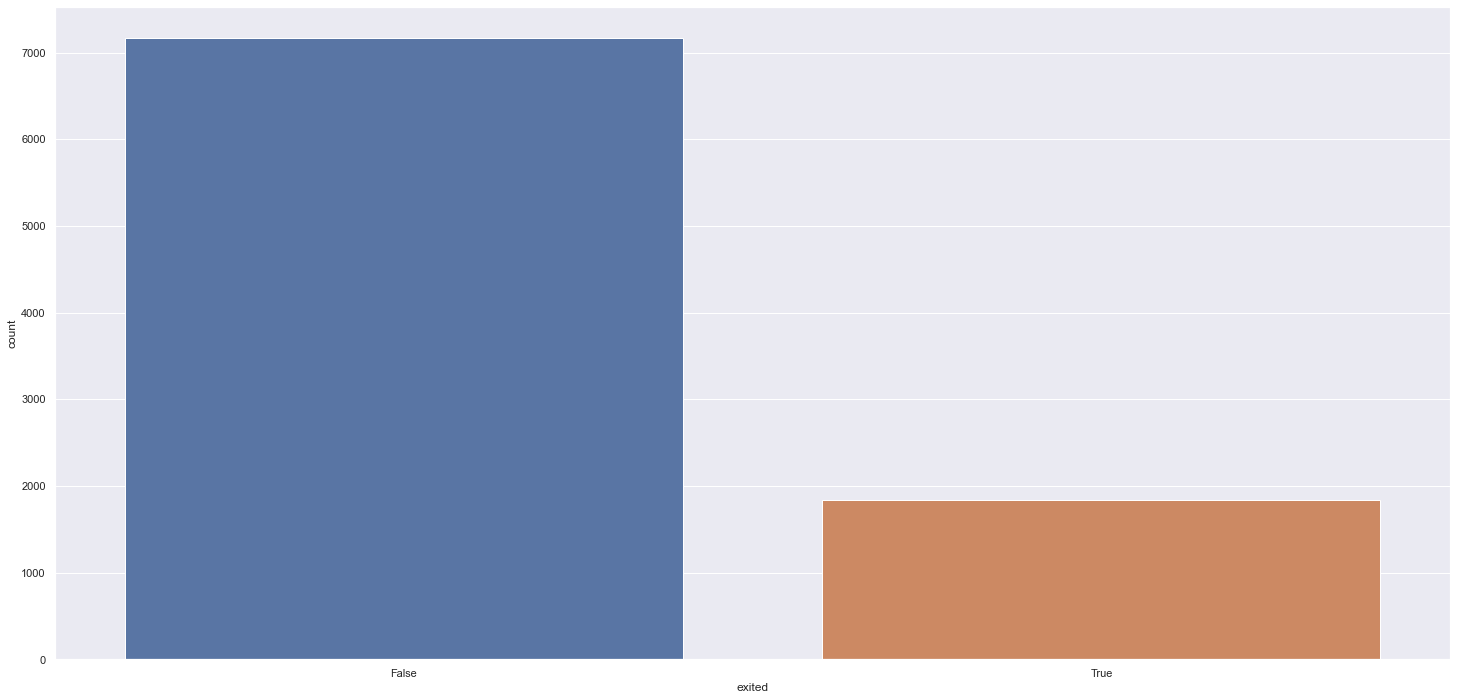

In [29]:
sns.countplot(x='exited', data=df03);

---
> - Conclusion: **Disbalanced Dataset** 
---

## 3.2 Univariate Analysis

### 3.2.1 Numerical Attributes

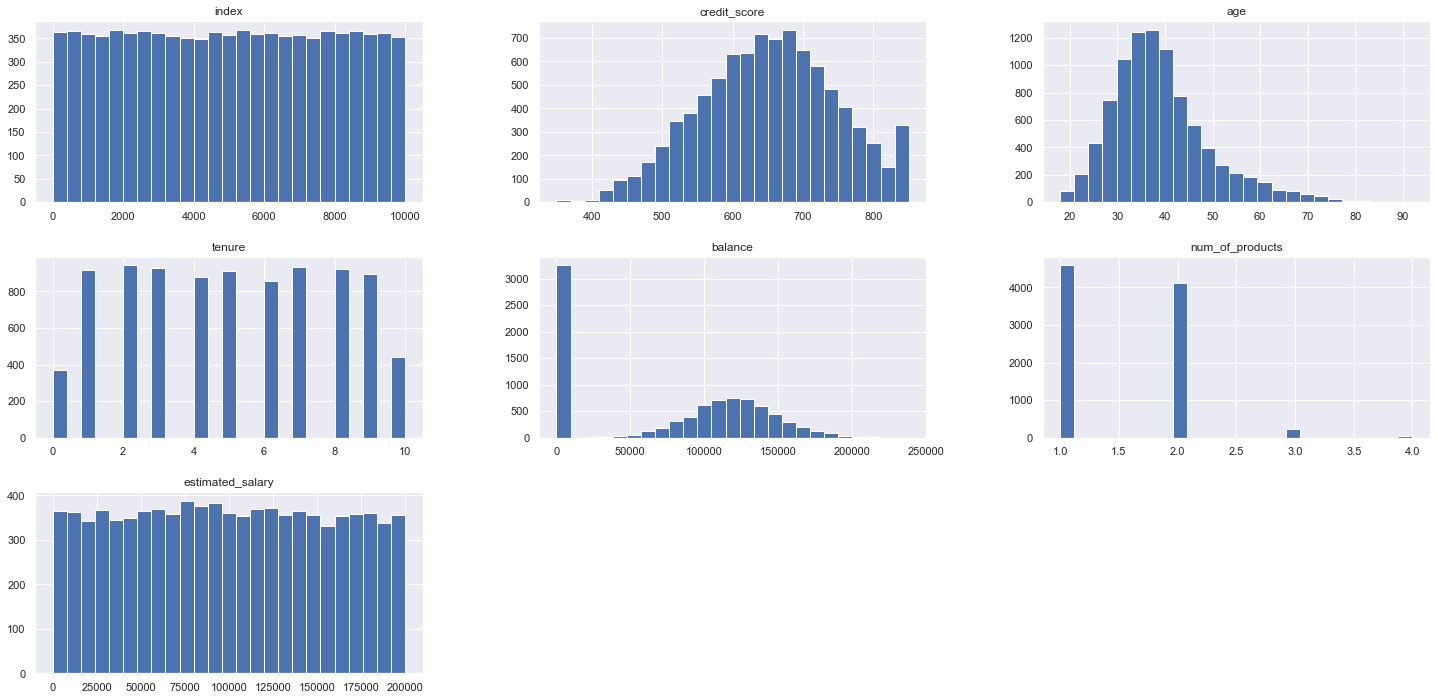

In [30]:
num_attributes.hist(bins=25);

### 3.2.2 Categorical Variable

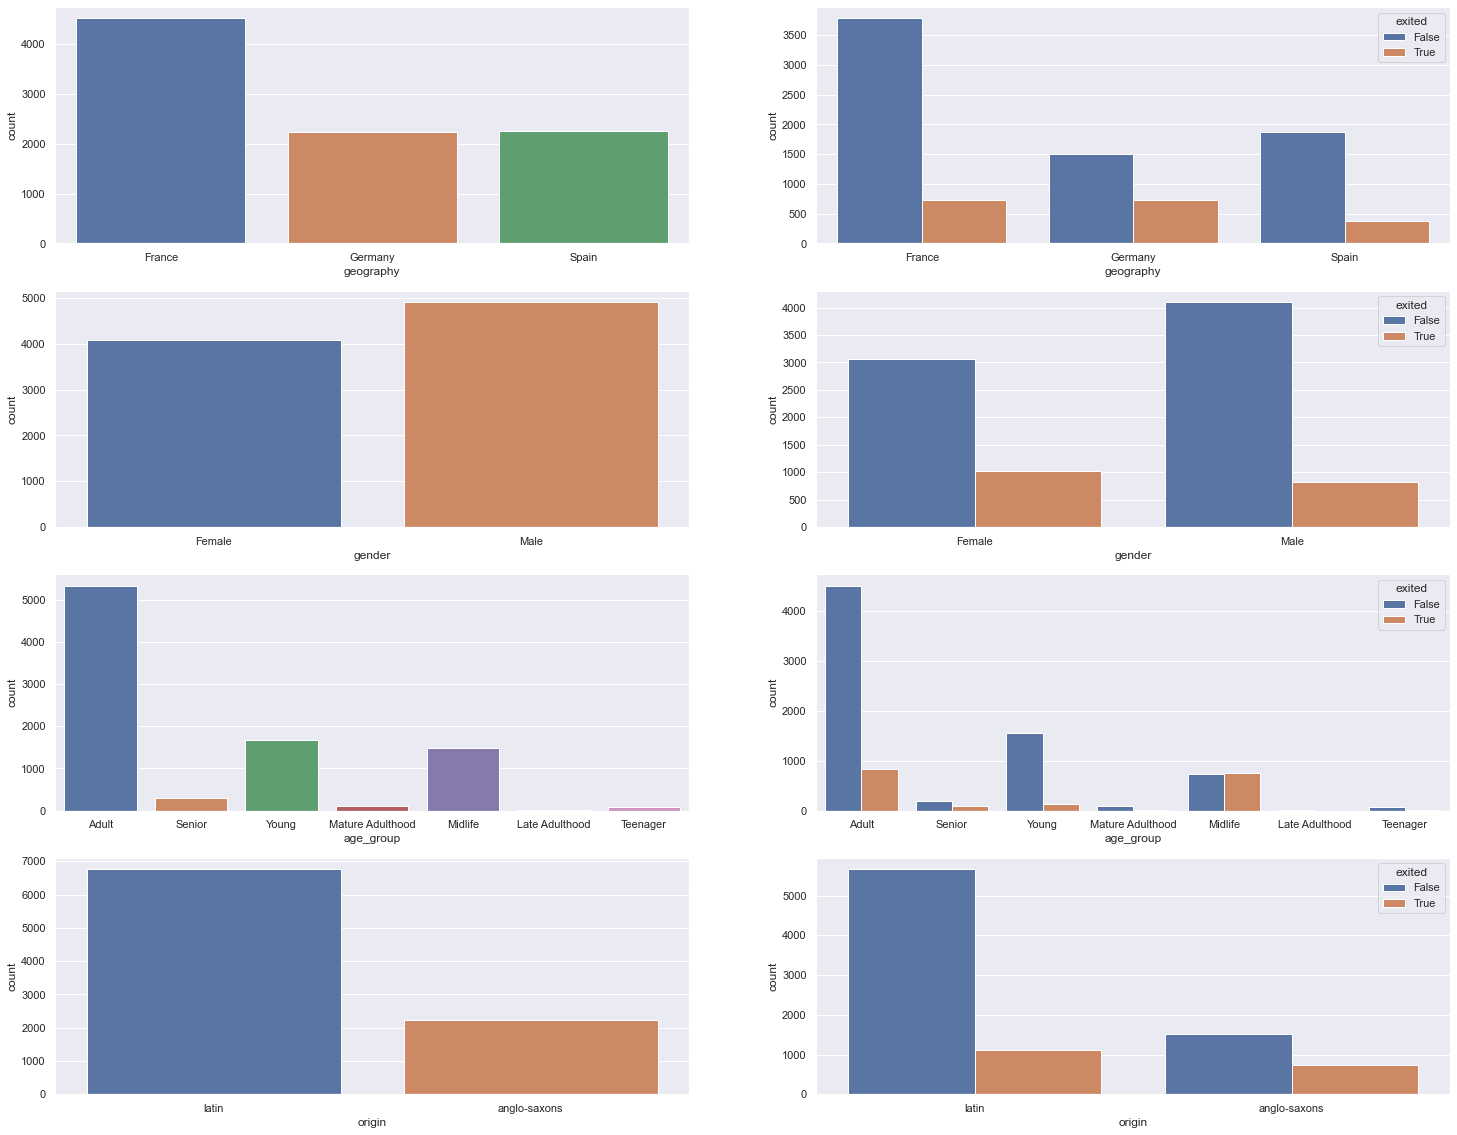

In [31]:
count = 1
attributes_to_inspect = ['geography', 'gender', 'age_group', 'origin']
rows= len(attributes_to_inspect)
plt.figure(figsize=(25,5*rows))
for i in attributes_to_inspect:
    plt.subplot(rows, 2, count)
    sns.countplot(x=i, data=df03)
    count += 1
    
    plt.subplot(rows, 2, count)
    sns.countplot(x=i, hue='exited', data=df03)
    count += 1
plt.show()

### 3.2.3 Boolean Attributes

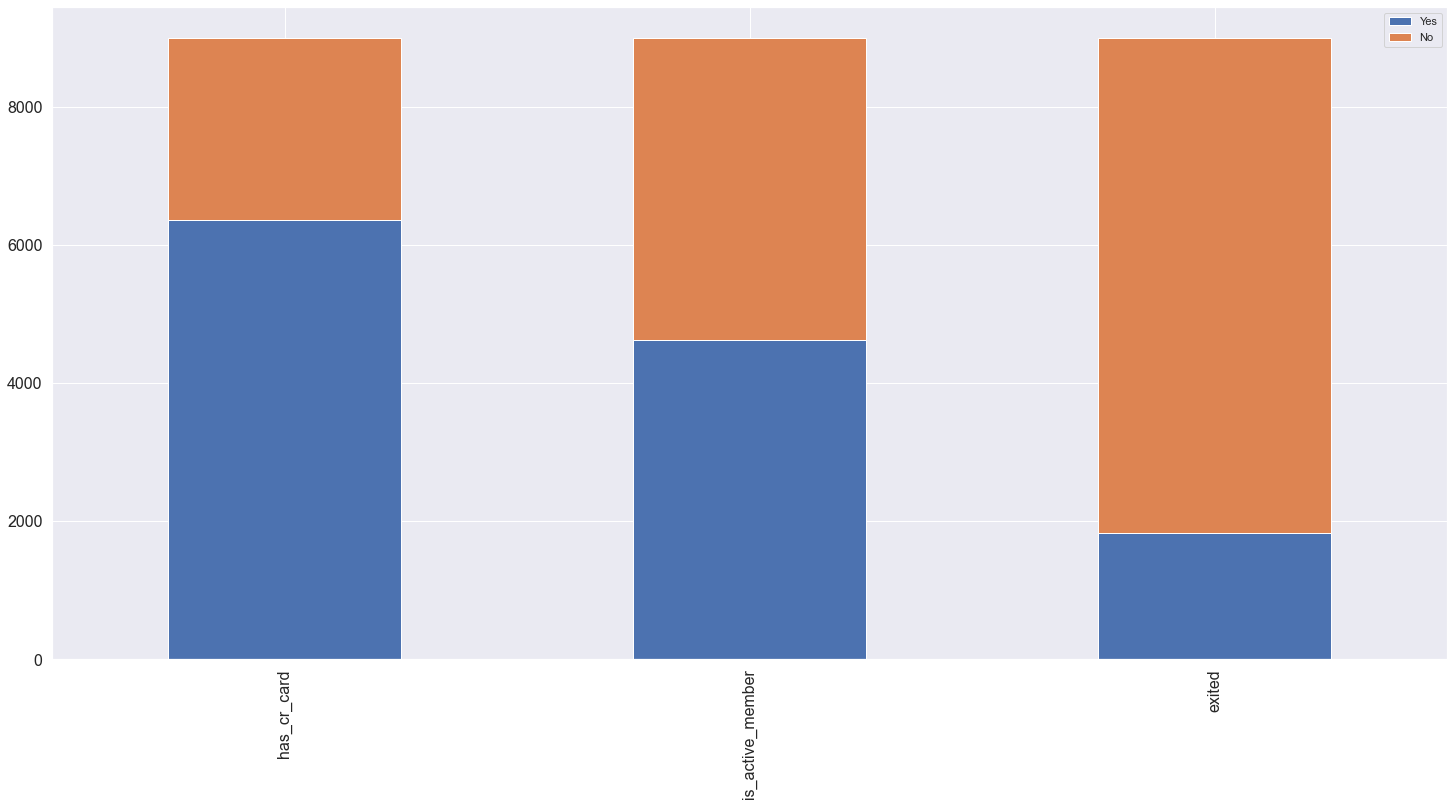

In [32]:
df_bool = pd.DataFrame(bool_attributes.apply(lambda x: x.sum())).rename(columns={0:"Yes"})
df_bool['No'] = df_bool['Yes'].apply(lambda row: df01.shape[0] - row)
df_bool.plot(kind='bar', stacked=True, fontsize=16);

## 3.3 Bivariate Analysis

### H01 - Men usually have more churn
---
> - Conclusion: **FALSE** 
>> **WOMEN** have more churn

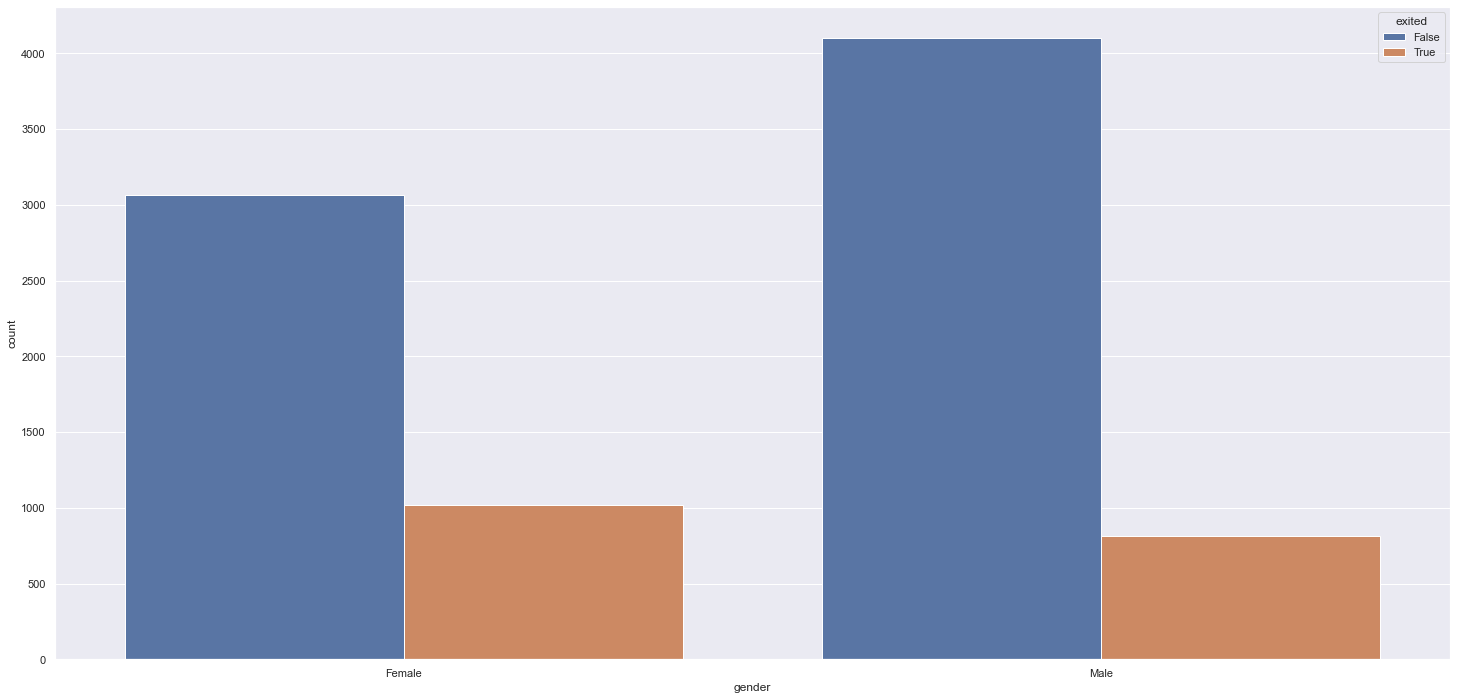

In [33]:
sns.countplot(x='gender', hue='exited', data=df03)
plt.show()

### H02 - Women usually buy more products
---
> - Conclusion: **FALSE** 
>> **MEN** usually buy more products

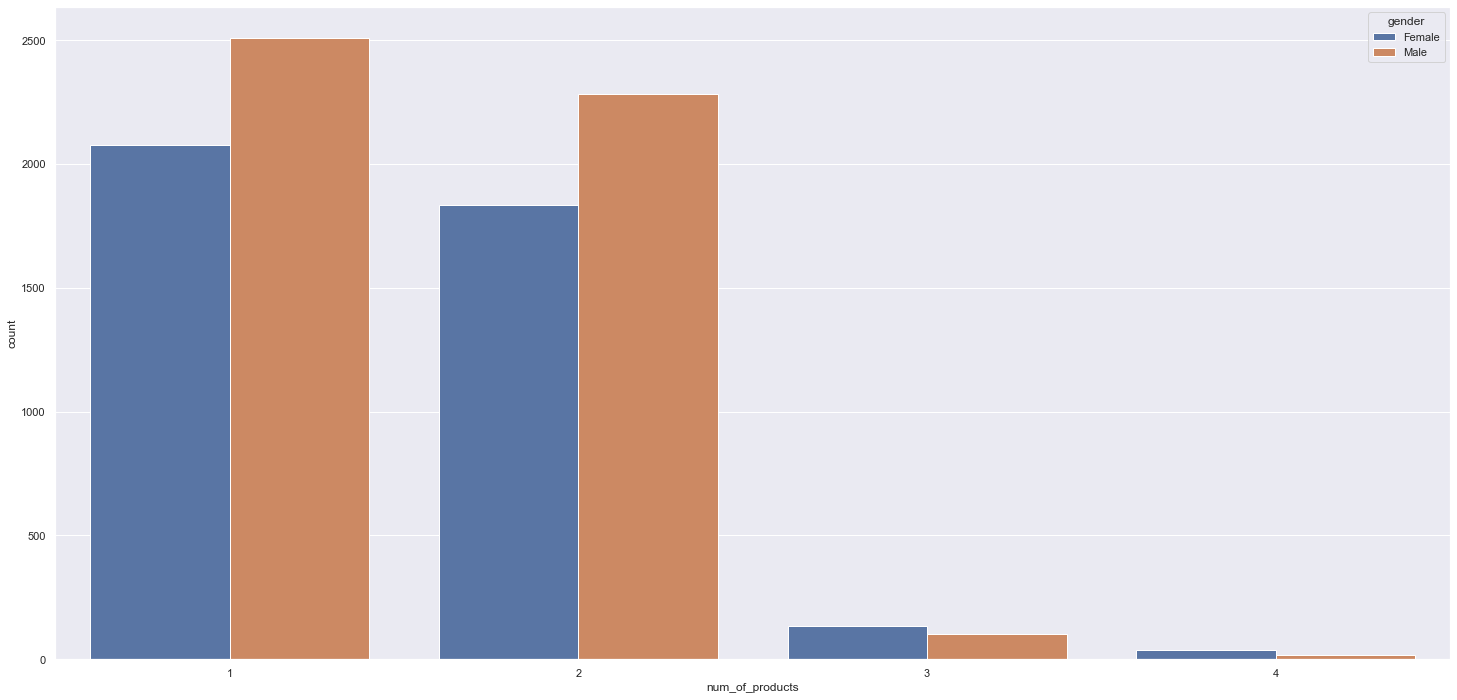

In [34]:
sns.countplot(x='num_of_products', hue='gender', data=df03);

### H03 - Younger clients are less loyal and more likely to leave a bank
---
> - Conclusion: **FALSE** 
>> Younger clients are **MORE** loyal and more likely to leave a bank

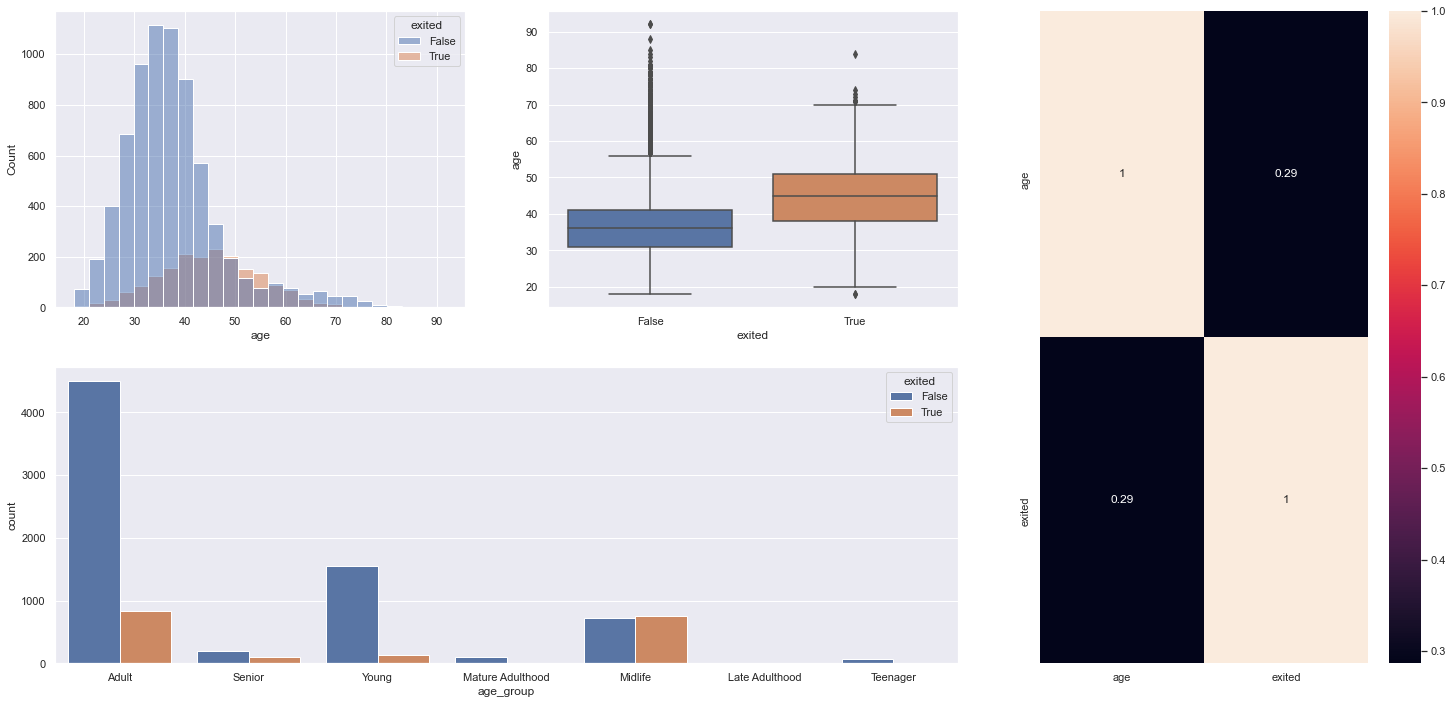

In [35]:
aux01 = df03[['age', 'age_group', 'exited']]

grid = GridSpec(2, 3)

plt.subplot(grid[0,0])
sns.histplot(x='age', bins=25, hue='exited', data=aux01);

plt.subplot(grid[0,1])
sns.boxplot(x='exited', y='age', data=aux01);

plt.subplot(grid[1,:2])
sns.countplot(x='age_group', hue='exited', data=aux01);

plt.subplot(grid[:,2])
sns.heatmap(aux01.corr(method='pearson'),annot=True);

### H04 - Clients with higher estimated wages have higher Churn Rate
---
> - Conclusion: **True** 
>> Clients with higher estimated wages have **higher** Churn Rate

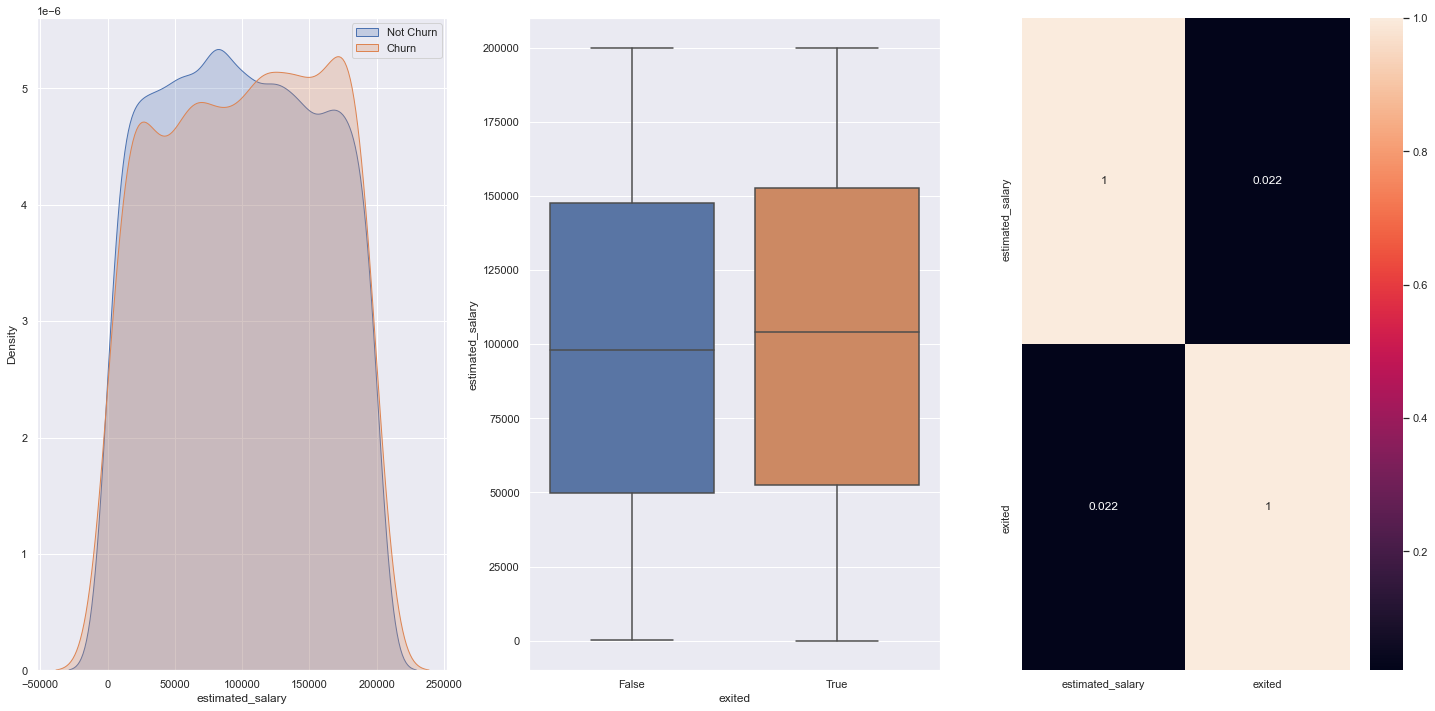

In [36]:
aux01 = df03[['estimated_salary', 'exited']]

plt.subplot(1,3,1)
sns.kdeplot(aux01[aux01['exited'] == False]['estimated_salary'], label='Not Churn', shade=True);
sns.kdeplot(aux01[aux01['exited'] == True]['estimated_salary'], label='Churn', shade=True);
plt.legend()

plt.subplot(1,3,2)
sns.boxplot(x="exited", y="estimated_salary", data=aux01);

plt.subplot(1,3,3)
sns.heatmap(aux01.corr(method='pearson'),annot=True);

### H05 - Countries of Latin origin have higher number of churn
---
> - Conclusion: **FALSE** 
>> Countries of **Anglo-Saxons** origin have higher number of churn

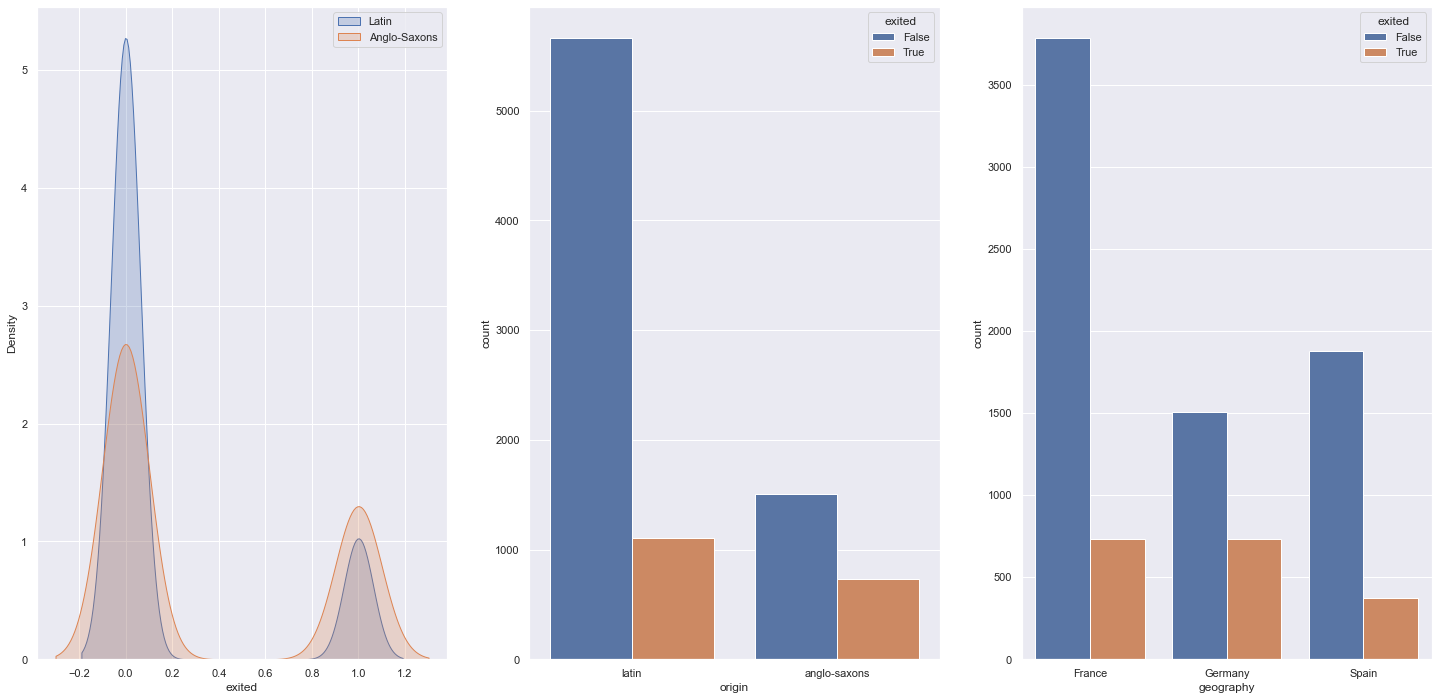

In [37]:
aux01 = df03[['origin', 'exited']]

plt.subplot(1,3,1)
sns.kdeplot(aux01[aux01['origin'] == 'latin']['exited'], label='Latin', shade=True);
sns.kdeplot(aux01[aux01['origin'] == 'anglo-saxons']['exited'], label='Anglo-Saxons', shade=True);
plt.legend()

plt.subplot(1,3,2)
sns.countplot(x='origin', hue='exited', data=aux01);

plt.subplot(1,3,3)
sns.countplot(x='geography', hue='exited', data=df03);

### H06 - Active members have less churn
---
> - Conclusion: **TRUE** 
>> Active members have less churn

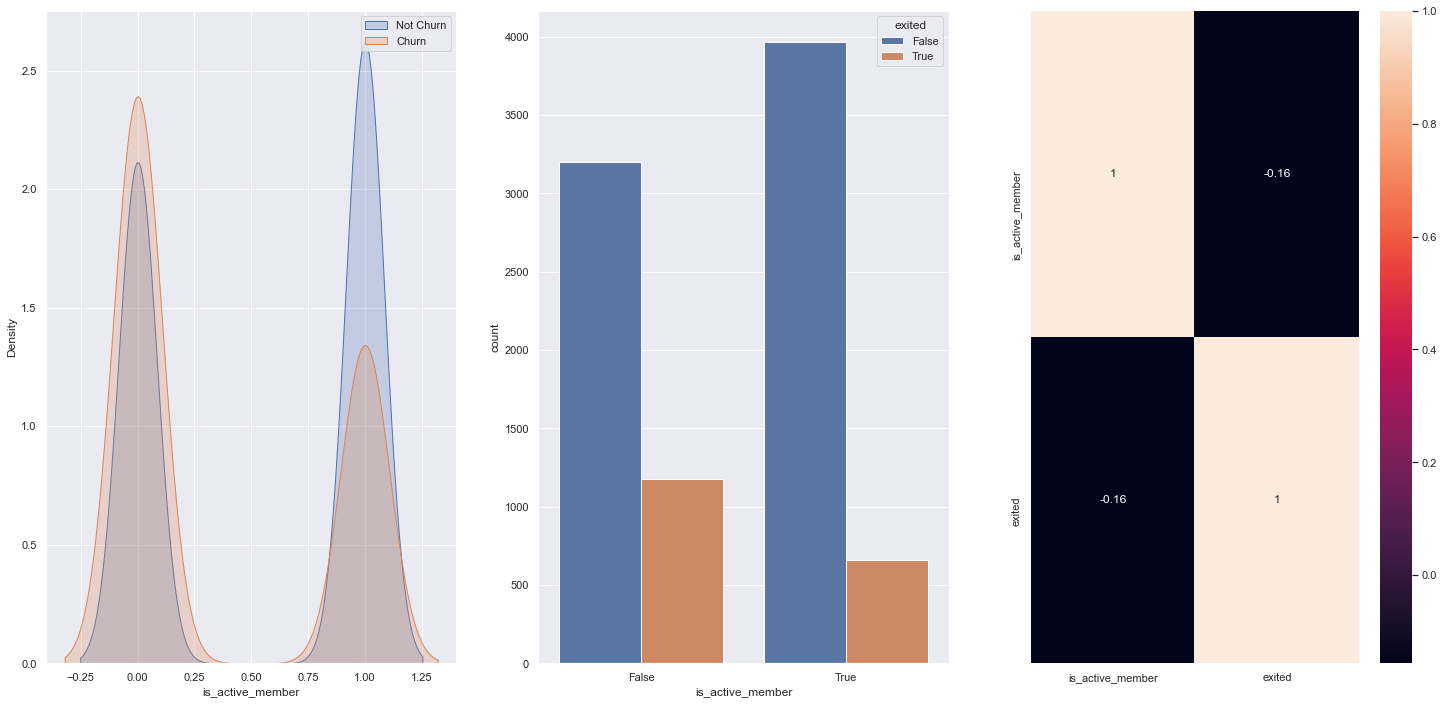

In [38]:
aux01 = df03[['is_active_member', 'exited']]

plt.subplot(1,3,1)
sns.kdeplot(aux01[aux01['exited'] == False]['is_active_member'], label='Not Churn', shade=True);
sns.kdeplot(aux01[aux01['exited'] == True]['is_active_member'], label='Churn', shade=True);
plt.legend()

plt.subplot(1,3,2)
sns.countplot(x='is_active_member', hue='exited', data=df03);

plt.subplot(1,3,3)
sns.heatmap(aux01.corr(method='pearson'),annot=True);

### H07 - Along the years Churn tends to be lower
---
> - Conclusion: **True** 
>> Along the years Churn had reduce

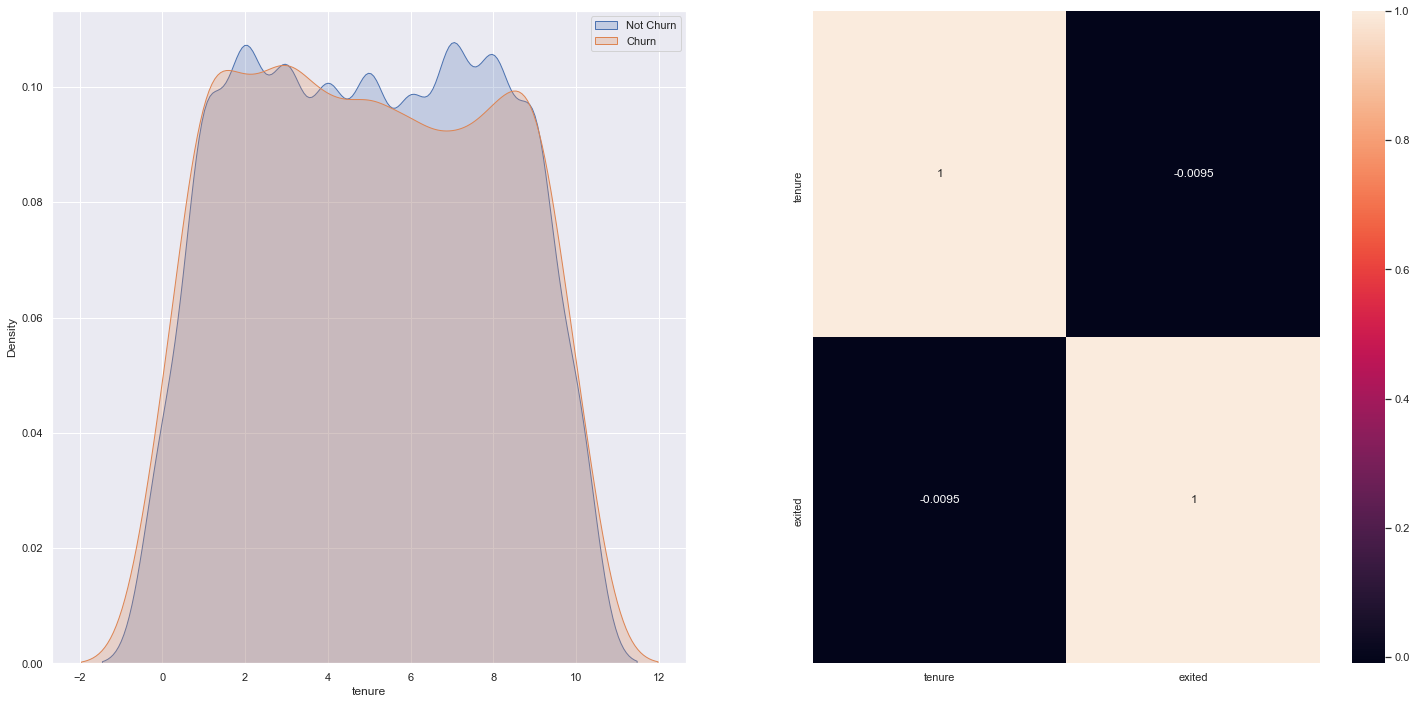

In [39]:
aux01 = df03[['tenure', 'exited']]

plt.subplot(1,2,1)
sns.kdeplot(aux01[aux01['exited'] == False]['tenure'], label='Not Churn', shade=True);
sns.kdeplot(aux01[aux01['exited'] == True]['tenure'], label='Churn', shade=True);
plt.legend()

plt.subplot(1,2,2)
sns.heatmap(aux01.corr(method='pearson'),annot=True);

### H08 - Customers with Credit Cards tend to stay at the bank
---
> - Conclusion: **FALSE** 
>> Customers with Credit Cards have a churn rate similar to customers without credit cards

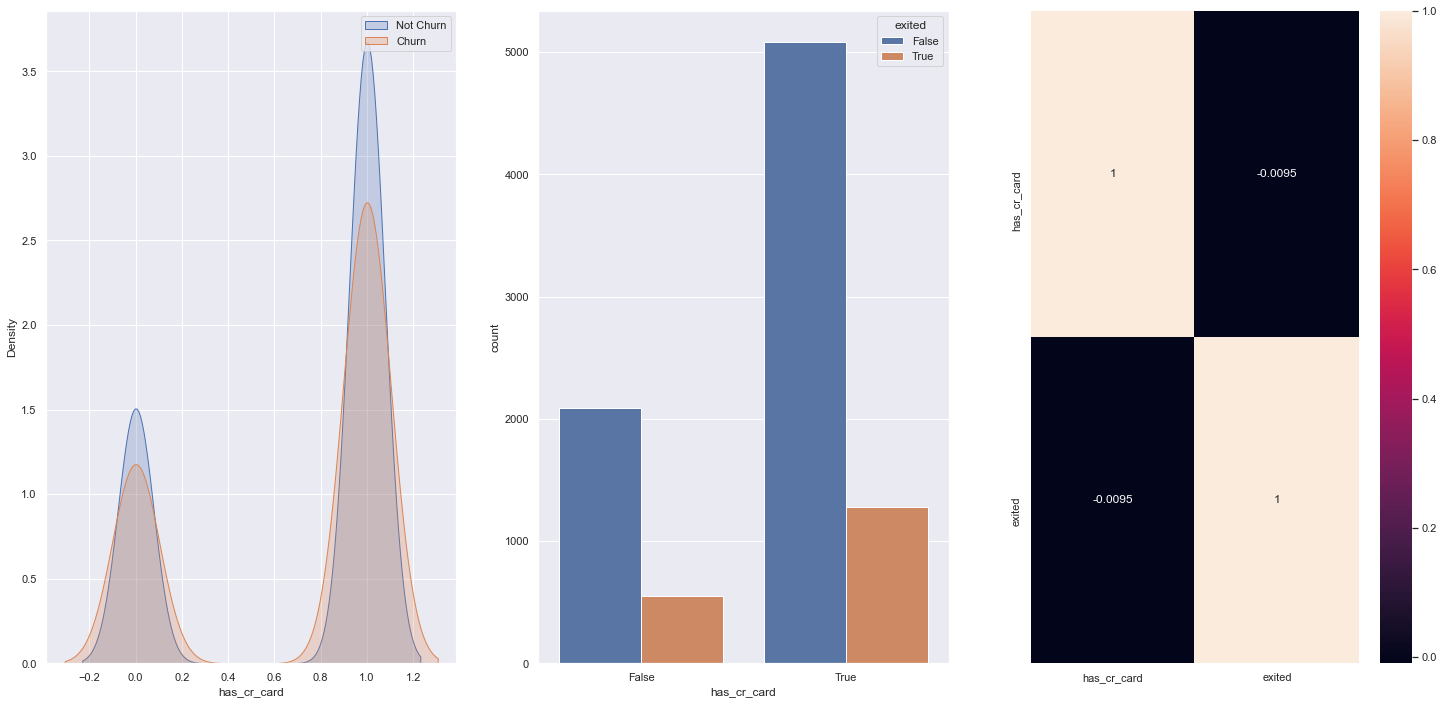

In [40]:
aux01 = df03[['has_cr_card', 'exited']]

plt.subplot(1,3,1)
sns.kdeplot(aux01[aux01['exited'] == False]['has_cr_card'], label='Not Churn', shade=True);
sns.kdeplot(aux01[aux01['exited'] == True]['has_cr_card'], label='Churn', shade=True);
plt.legend()

plt.subplot(1,3,2)
sns.countplot(x='has_cr_card', hue='exited', data=aux01);

plt.subplot(1,3,3)
sns.heatmap(aux01.corr(method='pearson'),annot=True);

### H09 - Customers with higher balance remain at the bank
---
> - Conclusion: **Trur** 
>> Customers with higher balance remain at the bank

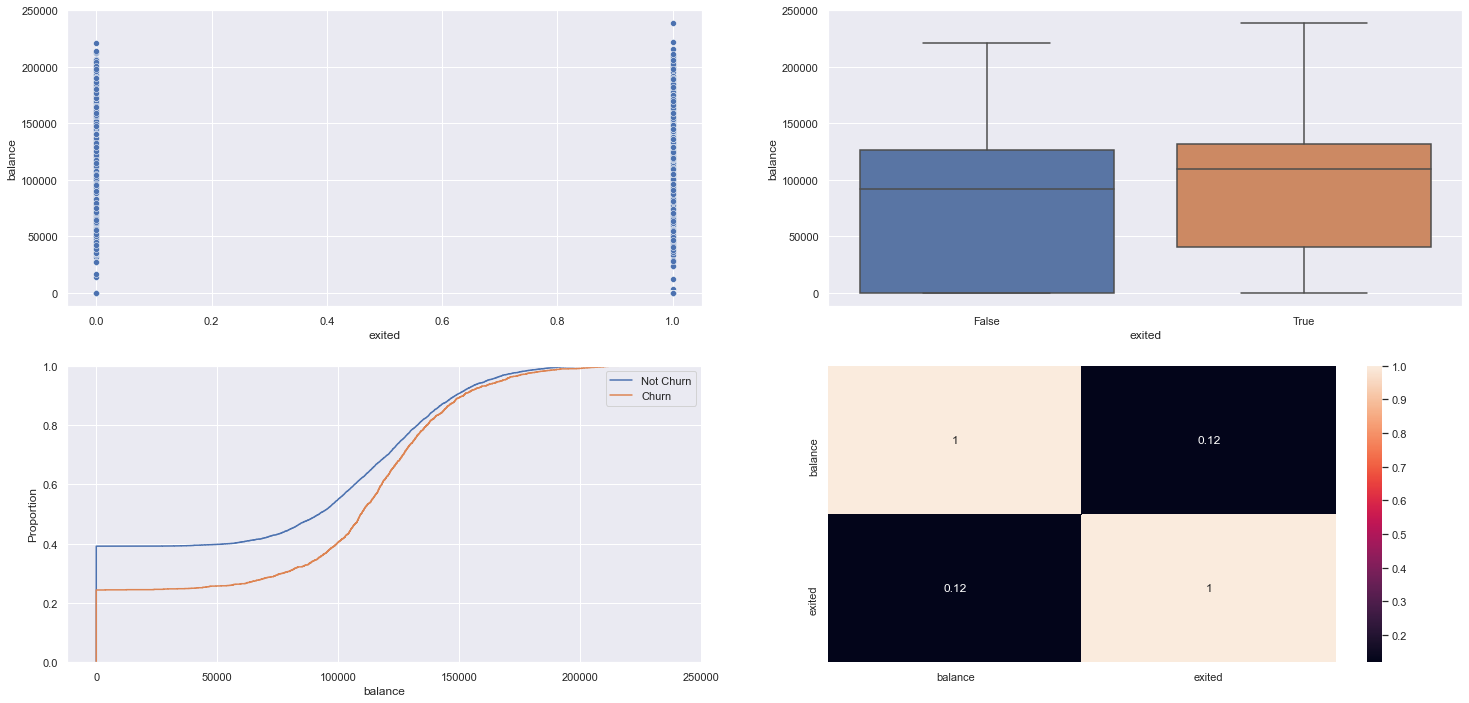

In [41]:
aux01 = df03[['balance', 'exited']]

plt.subplot(2,2,1)
sns.scatterplot(y='balance', x='exited', data=aux01);

plt.subplot(2,2,2)
sns.boxplot(y='balance', x='exited', data=aux01);

plt.subplot(2,2,3)
sns.ecdfplot(data=aux01[aux01['exited'] == False], x="balance", label='Not Churn');
sns.ecdfplot(data=aux01[aux01['exited'] == True], x="balance", label='Churn');
plt.legend()

plt.subplot(2,2,4)
sns.heatmap(aux01.corr(method='pearson'),annot=True);

## 3.4 Multivariate Analysis

### 3.4.1 Numerical and Boolean Attributes

In [42]:
# Numerical Attributes and Boolean
num_bool_attributes = pd.concat([num_attributes, bool_attributes], axis=1)
not_include = ['customer_id']
num_bool_attributes = num_bool_attributes[num_bool_attributes.columns[~num_bool_attributes.columns.isin(not_include)]]

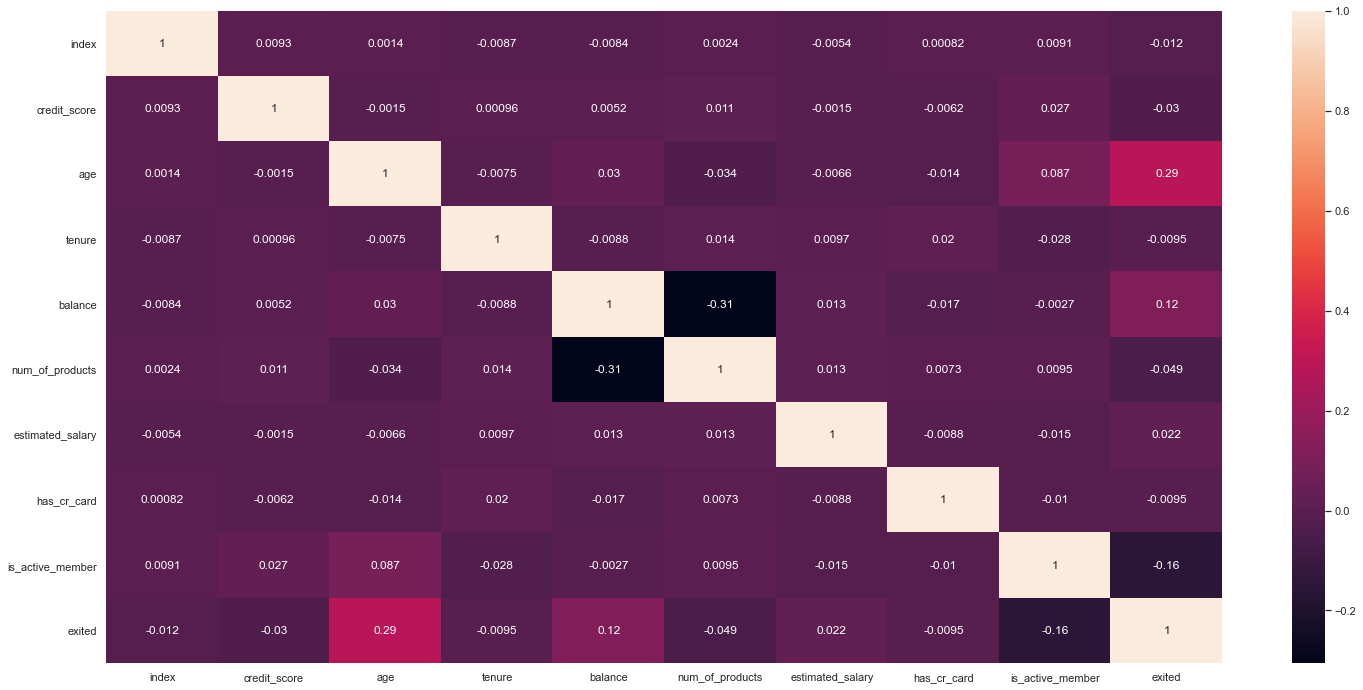

In [43]:
correlation = num_bool_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 3.4.2 Categorical Attributes

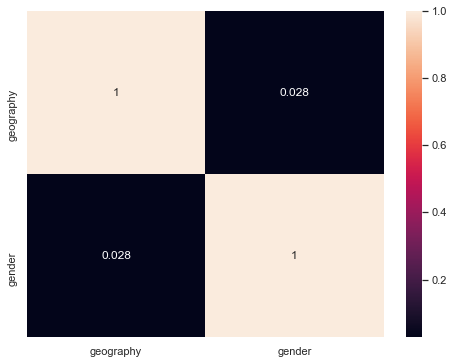

In [44]:
a1 = cramerV(cat_attributes['geography'], cat_attributes['geography'])
a2 = cramerV(cat_attributes['geography'], cat_attributes['gender'])

a3 = cramerV(cat_attributes['gender'], cat_attributes['geography'])
a4 = cramerV(cat_attributes['gender'], cat_attributes['gender'])

#Final Dataset
dict_cramerV = {
                'geography':[a1, a2],
                'gender':[a3, a4]
                }

d = pd.DataFrame(dict_cramerV)

d = d.set_index(d.columns)

#HeatMap Plot
plt.figure(figsize=(8,6))
sns.heatmap(d, annot=True)
plt.show()

# 4.0 DATA PREPARATION

In [45]:
df04 = df03.copy()

## 4.1 Change Dtypes (Boolean)

In [46]:
df04[df04.select_dtypes(include=['bool']).columns] = df04.select_dtypes(include=['bool']).astype(int)

## 4.2 Columns Filter 

In [47]:
#Categorical Attributes
to_drop = ['customer_id', 'surname']
df04 = df04.drop(to_drop, axis=1)

## 4.3 Transformation

### 4.3.1 Encoding

In [48]:
#AgeGroup -> One Hot Encoding
df04 = pd.get_dummies(df04, prefix=['age_group'], columns=['age_group'], drop_first=True)

#Geography -> One Hot Encoding
df04 = pd.get_dummies(df04, prefix=['geography'], columns=['geography'], drop_first=True)

# Gender
df04['gender'] = np.where(df04['gender'] == 'Female', 1, 0)

# origin
df04['origin'] = np.where(df04['origin'] == 'Latin', 1, 0)

### 4.3.2 ~~Normalization~~

### 4.3.3 Split Dataset into X and y

In [50]:
X_train = df04.drop(columns=['exited'], axis=1)
y_train = df04['exited']

### 4.3.4 Rescaling

In [51]:
# Numerical Attributes
num_attributes.head()

,index,credit_score,age,tenure,balance,num_of_products,estimated_salary
0,673,640,32,6,118879.35,2,19131.71
1,7709,598,64,1,62979.93,1,152273.57
2,6100,796,30,2,137262.71,2,62905.29
3,8469,720,71,5,183135.39,2,197688.50
4,8563,578,45,1,148600.91,1,143397.14


In [52]:
rs = RobustScaler()
mms = MinMaxScaler()

#Balance >> Presence of well defined outiliers 
X_train['balance'] = rs.fit_transform(X_train[['balance']].values)
jb.dump(rs,'03-Parameter/balance_scaler.pkl.z')

#CreditScore
X_train['credit_score'] = mms.fit_transform(X_train[['credit_score']].values)
jb.dump(mms,'03-Parameter/credit_score_scaler.pkl.z')

#Age
X_train['age'] = mms.fit_transform(X_train[['age']].values)
jb.dump(mms,'03-Parameter/age_scaler.pkl.z')

#Tenure
X_train['tenure'] = mms.fit_transform(X_train[['tenure']].values)
jb.dump(mms,'03-Parameter/tenure_scaler.pkl.z')

#NumOfProducts
X_train['num_of_products'] = mms.fit_transform(X_train[['num_of_products']].values)
jb.dump(mms,'03-Parameter/num_of_products_scaler.pkl.z')

#EstimatedSalary
X_train['estimated_salary'] = mms.fit_transform(X_train[['estimated_salary']].values)
jb.dump(mms,'03-Parameter/estimated_salary_scaler.pkl.z')

['03-Parameter/estimated_salary_scaler.pkl.z']

# 5.0 FEATURE SELECTION

In [53]:
df05 = df04.copy()

## 5.1 Boruta as Feature Selector

In [54]:
# Training and Validation dataset for Boruta
X_train_n = X_train.to_numpy()
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestClassifier(n_jobs=-1)

# define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=42)
boruta.fit(X_train_n, y_train_n)

BorutaPy(estimator=RandomForestClassifier(n_estimators=31, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x287AA906140),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x287AA906140)

In [55]:
cols_selected = boruta.support_.tolist()

# Best Features
X_train_fs = X_train
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()

cols_not_select_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))
cols_selected_boruta

['age', 'balance', 'num_of_products', 'estimated_salary']

# 6.0 MACHINE LEARNING MODELLING

In [56]:
df06 = df05.copy()

## 6.1 Data Balancing

In [112]:
# Train
y_train = y_train
X_train = X_train[cols_selected_boruta]

# set the resampler
resampler = SMOTETomek(random_state=42, n_jobs=-1)
jb.dump(resampler,'03-Parameter/resampler.pkl.z')
# resample the dataset
X_balanced, y_balanced = resampler.fit_resample(X_train, y_train)

df_train = pd.concat([X_balanced, y_balanced], axis=1)

Text(0.5, 1.0, 'After SMOTE')

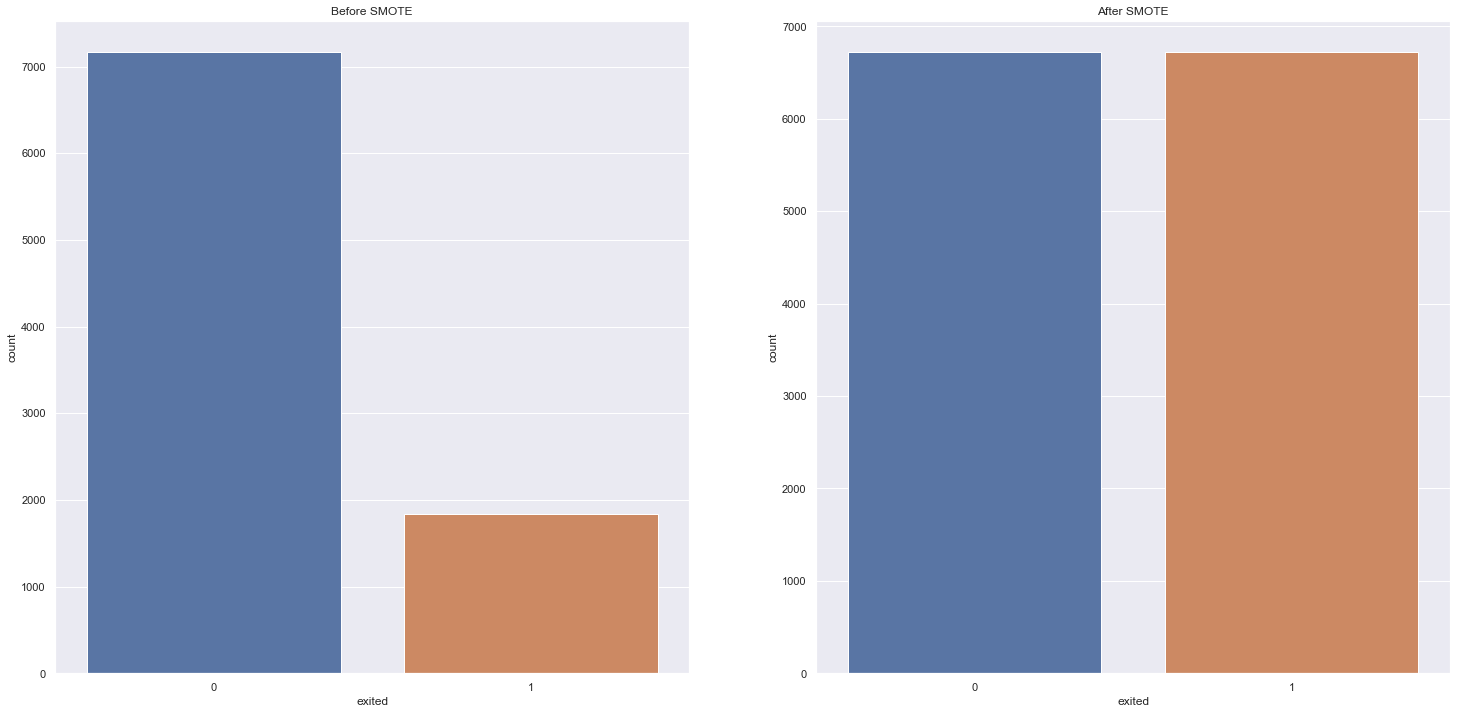

In [108]:
# plots before and after SMOTE
plt.subplot(1,2,1)
sns.countplot(x=y_train);
plt.title("Before SMOTE")

plt.subplot(1,2,2)
sns.countplot(x=y_balanced);
plt.title("After SMOTE")

## 6.2 Modelling

### 6.2.1 Split Data into Training and Validation Dataset

In [109]:
X_tr, X_valid, y_tr, y_valid = train_test_split(X_balanced, y_balanced, test_size=.2, random_state=42)

### 6.2.2 Logistic Regression

#### 6.2.2.1 Without Cross Validation

In [110]:
#Model
model_name = 'Logistic Regression'
model_lr = LogisticRegression()
model_lr.fit(X_tr, y_tr)

# Prediction
yhat_lr = model_lr.predict(X_valid)

# Prediction Proba
yhat_proba_lr = model_lr.predict_proba(X_valid)[:,1]

model_lr_result = ml_scores(model_name, y_valid, yhat_lr, yhat_proba_lr)
model_lr_result.head()

,Model Name,Precision,Recall,F1 Score,Kappa,Average Precision Score,ROC AUC
0,Logistic Regression,0.71118,0.691321,0.70111,0.418761,0.690869,0.76414


#### 6.2.2.2 With Cross Validation

In [111]:
# Model
model_lr = LogisticRegression()
# Performance
model_lr_result_cv = cross_validation(df_train, 10, 'Logistic Regression', model_lr, verbose=False)
model_lr_result_cv.head()

,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Average Precision Score CV,ROC AUC CV
0,Logistic Regression,0.7078 +/- 0.0228,0.6961 +/- 0.0227,0.7014 +/- 0.0141,0.4096 +/- 0.0307,0.6934 +/- 0.0198,0.7592 +/- 0.0156


### 6.2.3 Lightgbm Classifier

#### 6.2.3.1 Without Cross Validation

In [106]:
#Model
model_name = 'Lightgbm Classifier'
model_lgbm = LGBMClassifier(n_jobs=-1, random_state=42, n_estimators=500)
model_lgbm.fit(X_tr, y_tr)

# Prediction
yhat_lgbm = model_lgbm.predict(X_valid)

# Prediction Proba
yhat_proba_lgbm = model_lgbm.predict_proba(X_valid)[:,1]

model_lgbm_result = ml_scores(model_name, y_valid, yhat_lgbm, yhat_proba_lgbm)
model_lgbm_result.head()

,Model Name,Precision,Recall,F1 Score,Kappa,Average Precision Score,ROC AUC
0,Lightgbm Classifier,0.576336,0.415978,0.4832,0.378041,0.555649,0.790952


#### 6.2.3.2 With Cross Validation

In [63]:
# Model
model_lgbm = LGBMClassifier(n_jobs=-1, random_state=42, n_estimators=500)
# Performance
model_lgbm_result_cv = cross_validation(df_train, 10, 'Lightgbm Classifier', model_lgbm, verbose=False)
model_lgbm_result_cv.head()

,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Average Precision Score CV,ROC AUC CV
0,Lightgbm Classifier,0.8667 +/- 0.0381,0.8575 +/- 0.0356,0.8619 +/- 0.0353,0.7256 +/- 0.0722,0.9362 +/- 0.0353,0.9328 +/- 0.0304


### 6.2.4 Random Forest Classifier

#### 6.2.4.1 Without Cross Validation

In [64]:
#Model
model_name = 'Random Forest Classifier'
model_rf = RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=500)
model_rf.fit(X_tr, y_tr)

# Prediction
yhat_rf = model_rf.predict(X_valid)

# Prediction Proba
yhat_proba_rf = model_rf.predict_proba(X_valid)[:,1]

model_rf_result = ml_scores(model_name, y_valid, yhat_rf, yhat_proba_rf)
model_rf_result.head()

,Model Name,Precision,Recall,F1 Score,Kappa,Average Precision Score,ROC AUC
0,Random Forest Classifier,0.881531,0.904151,0.892697,0.785827,0.953634,0.957043


#### 6.2.4.2 With Cross Validation

In [65]:
# Model
model_rf = RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=500)
# Performance
model_rf_result_cv = cross_validation(df_train, 10, 'Random Forest Classifier', model_rf, verbose=False)
model_rf_result_cv.head()

,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Average Precision Score CV,ROC AUC CV
0,Random Forest Classifier,0.858 +/- 0.0359,0.8611 +/- 0.0334,0.8594 +/- 0.0334,0.7195 +/- 0.0635,0.9256 +/- 0.0303,0.9292 +/- 0.0263


## 6.2.5 XGBoost Classifier

#### 6.2.5.1 Without Cross Validation

In [66]:
#Model
model_name = 'XGBoost Classifier'
model_xgb = XGBClassifier(n_jobs=-1, random_state=42, n_estimators=500)
model_xgb.fit(X_tr, y_tr)

# Prediction
yhat_xgb = model_xgb.predict(X_valid)

# Prediction Proba
yhat_proba_xgb = model_xgb.predict_proba(X_valid)[:,1]

model_xgb_result = ml_scores(model_name, y_valid, yhat_xgb, yhat_proba_xgb)
model_xgb_result.head()

,Model Name,Precision,Recall,F1 Score,Kappa,Average Precision Score,ROC AUC
0,XGBoost Classifier,0.892356,0.863396,0.877637,0.762577,0.957625,0.95167


#### 6.2.5.2 With Cross Validation

In [67]:
# Model
model_xgb = XGBClassifier(n_jobs=-1, random_state=42, n_estimators=500)
# Performance
model_xgb_result_cv = cross_validation(df_train, 10, 'XGBoost Classifier', model_xgb, verbose=False)
model_xgb_result_cv.head()

,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Average Precision Score CV,ROC AUC CV
0,XGBoost Classifier,0.8694 +/- 0.034,0.8537 +/- 0.0229,0.8614 +/- 0.0271,0.7266 +/- 0.0526,0.9358 +/- 0.033,0.9326 +/- 0.0249


### 6.2.5 Compare Performance

#### 6.2.5.1 Single Performance

In [68]:
modelling_result = pd.concat([model_lr_result, model_lgbm_result, model_rf_result, model_xgb_result], axis=0).reset_index(drop=True)
modelling_result.head()

,Model Name,Precision,Recall,F1 Score,Kappa,Average Precision Score,ROC AUC
0,Logistic Regression,0.711180,0.691321,0.701110,0.418761,0.690869,0.764140
1,Lightgbm Classifier,0.894696,0.865660,0.879939,0.767043,0.958278,0.954035
2,Random Forest Classifier,0.881531,0.904151,0.892697,0.785827,0.953634,0.957043
3,XGBoost Classifier,0.892356,0.863396,0.877637,0.762577,0.957625,0.951670


#### 6.2.5.2 Real Performance - Cross Validation

In [69]:
modelling_result_cv = pd.concat([model_lr_result_cv, model_lgbm_result_cv, model_rf_result_cv, model_xgb_result_cv], axis=0).reset_index(drop=True)
modelling_result_cv.head()

,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Average Precision Score CV,ROC AUC CV
0,Logistic Regression,0.7012 +/- 0.0244,0.6987 +/- 0.024,0.6995 +/- 0.0171,0.4034 +/- 0.0296,0.6916 +/- 0.0211,0.7576 +/- 0.0129
1,Lightgbm Classifier,0.8667 +/- 0.0381,0.8575 +/- 0.0356,0.8619 +/- 0.0353,0.7256 +/- 0.0722,0.9362 +/- 0.0353,0.9328 +/- 0.0304
2,Random Forest Classifier,0.858 +/- 0.0359,0.8611 +/- 0.0334,0.8594 +/- 0.0334,0.7195 +/- 0.0635,0.9256 +/- 0.0303,0.9292 +/- 0.0263
3,XGBoost Classifier,0.8694 +/- 0.034,0.8537 +/- 0.0229,0.8614 +/- 0.0271,0.7266 +/- 0.0526,0.9358 +/- 0.033,0.9326 +/- 0.0249


# 7.0 HYPERPARAMETER FINE TUNING

## 7.1 MODELS
---
- Lightgbm Classifier
- Random Forest Classifier
- XGBoost Classifier

## 7.2 DataFrame with results Declare

In [70]:
df_lgbm_results = pd.DataFrame()
df_rf_results = pd.DataFrame()
df_xgb_results = pd.DataFrame()

## 7.3 Lightgbm Classifier

In [71]:
def tune_lgbm(params):
    print(params)
    lr = params[0]
    max_depth = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    n_estimators = params[5]
    
    dict_params = {'learning_rate': lr,
                 'max_depth': max_depth,
                 'min_child_samples': min_child_samples,
                 'subsample': subsample,
                 'colsample_bytree': colsample_bytree,
                 'n_estimators': n_estimators}
    
    model_name = 'Lightgbm Classifier'
    kfold = 10
    
    precision_list = []
    recall_list = []
    f1_list = []
    kappa_list = []
    ap_list = []
    roc_auc_list = []
    param_list =[]
    X_training = df_train.sample(frac=1).reset_index(drop=True)
    for k in reversed(range(1, kfold+1)):
        
        # Filtering Dataset
        training = X_training.iloc[0: k*(round(X_training.shape[0]/(kfold+1))), :]
        validation = X_training.iloc[k*(round(X_training.shape[0]/(kfold+1))) : (k+1)*(round(X_training.shape[0]/(kfold+1))), :]

        # Training and Validation Dataset
        # Training
        X_kfold_training = training.drop(['exited'], axis=1)
        y_kfold_training = training['exited']

        # Validation
        X_kfold_validation = validation.drop(['exited'], axis=1)
        y_kfold_validation = validation['exited']
        
        
    
        model = LGBMClassifier(learning_rate=lr, num_leaves=2 ** max_depth, max_depth=max_depth,
                               min_child_samples=min_child_samples, subsample=subsample, colsample_bytree=colsample_bytree,
                               bagging_freq=1, n_estimators=n_estimators, random_state=0, class_weight='balanced', n_jobs=-1)
    
    
        #Model
        model.fit(X_kfold_training, y_kfold_training)
    
           # Prediction
        yhat = model.predict(X_kfold_validation)
        
        # Prediction Proba
        yhat_proba = model.predict_proba(X_kfold_validation)[:,1]
                #Performance
        model_result = ml_scores(model_name, y_kfold_validation, yhat, yhat_proba)
        
        #Store Performance of each KFold iteration
        precision_list.append(model_result['Precision'].tolist())
        recall_list.append(model_result['Recall'].tolist())
        f1_list.append(model_result['F1 Score'].tolist())
        kappa_list.append(model_result['Kappa'].tolist())
        ap_list.append(model_result['Average Precision Score'].tolist())
        roc_auc_list.append(model_result['ROC AUC'].tolist())
        param_list.append(dict_params)
    

    dict_result = {
                    'Model Name': [model_name],
                    'Precision CV': [np.round(np.mean(precision_list),4).astype(str) + ' +/- ' + np.round(np.std(precision_list),4).astype(str)],
                    'Recall CV': [np.round(np.mean(recall_list),4).astype(str) + ' +/- ' + np.round(np.std(recall_list),4).astype(str)],
                    'F1 Score CV': [np.round(np.mean(f1_list),4).astype(str) + ' +/- ' + np.round(np.std(f1_list),4).astype(str)],
                    'Kappa CV': [np.round(np.mean(kappa_list),4).astype(str) + ' +/- ' + np.round(np.std(kappa_list),4).astype(str)],
                    'Average Precision Score CV': [np.round(np.mean(ap_list),4).astype(str) + ' +/- ' + np.round(np.std(ap_list),4).astype(str)],
                    'ROC AUC CV': [np.round(np.mean(roc_auc_list),4).astype(str) + ' +/- ' + np.round(np.std(roc_auc_list),4).astype(str)],
                    'Params': [param_list]
                }

    
    df_metrics = pd.DataFrame(dict_result)
    global df_lgbm_results
    df_lgbm_results = pd.concat([df_metrics, df_lgbm_results], axis=0)
    
    return -np.mean(ap_list)

space = [(1e-3, 1e-1, 'log-uniform'), #lr
        (1, 10), #max_depth
        (1, 20), #min_child_samples
        (0.05, 1.0), #subsample
        (0.05, 1.0), #colsample_bytree
        (100, 1000)] #n_estimetors



result = forest_minimize(tune_lgbm, space, random_state=160745, n_random_starts=20, n_calls=20, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
[0.009944912110647982, 5, 1, 0.4677107511929402, 0.49263223036174764, 272]
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

In [72]:
result_lgbm = result.x
result_lgbm

[0.016490254525097375, 9, 9, 0.6502182010234373, 0.6866210554187129, 828]

In [73]:
df_lgbm_results.head()

,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Average Precision Score CV,ROC AUC CV,Params
0,Lightgbm Classifier,0.7756 +/- 0.0263,0.7578 +/- 0.0277,0.7663 +/- 0.0222,0.5376 +/- 0.0408,0.8502 +/- 0.0193,0.8492 +/- 0.0158,"[{'learning_rate': 0.003859705757436628, 'max_..."
0,Lightgbm Classifier,0.8698 +/- 0.0138,0.8299 +/- 0.0287,0.8492 +/- 0.0203,0.706 +/- 0.0373,0.9279 +/- 0.0129,0.9227 +/- 0.015,"[{'learning_rate': 0.0066328042405379645, 'max..."
0,Lightgbm Classifier,0.8759 +/- 0.033,0.8448 +/- 0.0232,0.8599 +/- 0.026,0.7241 +/- 0.0473,0.9384 +/- 0.0262,0.9352 +/- 0.021,"[{'learning_rate': 0.061810855225848234, 'max_..."
0,Lightgbm Classifier,0.8297 +/- 0.0188,0.8016 +/- 0.0165,0.8153 +/- 0.0158,0.635 +/- 0.0316,0.8938 +/- 0.0138,0.8931 +/- 0.0129,"[{'learning_rate': 0.015665337619230394, 'max_..."
0,Lightgbm Classifier,0.8067 +/- 0.0108,0.7463 +/- 0.0147,0.7753 +/- 0.0098,0.5688 +/- 0.0181,0.8686 +/- 0.0082,0.8655 +/- 0.0074,"[{'learning_rate': 0.0022449729419144397, 'max..."


## 7.4 Random Forest Classifier

In [74]:
def tune_rf(params):
    print(params)
    max_depth = params[0]
    min_samples_leaf = params[1]
    n_estimators = params[2]
    
    dict_params = {'max_depth': max_depth,
                  'min_samples_leaf': min_samples_leaf,
                  'n_estimators': n_estimators}
    
    
    mode_name = 'Random Forest Classifier'
    kfold = 10
    
    precision_list = []
    recall_list = []
    f1_list = []
    kappa_list = []
    ap_list = []
    roc_auc_list = []
    param_list =[]
    X_training = df_train.sample(frac=1).reset_index(drop=True)
    for k in reversed(range(1, kfold+1)):
        
        # Filtering Dataset
        training = X_training.iloc[0: k*(round(X_training.shape[0]/(kfold+1))), :]
        validation = X_training.iloc[k*(round(X_training.shape[0]/(kfold+1))) : (k+1)*(round(X_training.shape[0]/(kfold+1))), :]

        # Training and Validation Dataset
        # Training
        X_kfold_training = training.drop(['exited'], axis=1)
        y_kfold_training = training['exited']

        # Validation
        X_kfold_validation = validation.drop(['exited'], axis=1)
        y_kfold_validation = validation['exited']
        
        
        #Model
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=0,
                                           class_weight='balanced', n_jobs=-1)
    
    
        
        model.fit(X_kfold_training, y_kfold_training)
    
           # Prediction
        yhat = model.predict(X_kfold_validation)
        
        # Prediction Proba
        yhat_proba = model.predict_proba(X_kfold_validation)[:,1]
                #Performance
        model_result = ml_scores(model_name, y_kfold_validation, yhat, yhat_proba)
        
        #Store Performance of each KFold iteration
        precision_list.append(model_result['Precision'].tolist())
        recall_list.append(model_result['Recall'].tolist())
        f1_list.append(model_result['F1 Score'].tolist())
        kappa_list.append(model_result['Kappa'].tolist())
        ap_list.append(model_result['Average Precision Score'].tolist())
        roc_auc_list.append(model_result['ROC AUC'].tolist())
        param_list.append(dict_params)

    dict_result = {
                    'Model Name': [model_name],
                    'Precision CV': [np.round(np.mean(precision_list),4).astype(str) + ' +/- ' + np.round(np.std(precision_list),4).astype(str)],
                    'Recall CV': [np.round(np.mean(recall_list),4).astype(str) + ' +/- ' + np.round(np.std(recall_list),4).astype(str)],
                    'F1 Score CV': [np.round(np.mean(f1_list),4).astype(str) + ' +/- ' + np.round(np.std(f1_list),4).astype(str)],
                    'Kappa CV': [np.round(np.mean(kappa_list),4).astype(str) + ' +/- ' + np.round(np.std(kappa_list),4).astype(str)],
                    'Average Precision Score CV': [np.round(np.mean(ap_list),4).astype(str) + ' +/- ' + np.round(np.std(ap_list),4).astype(str)],
                    'ROC AUC CV': [np.round(np.mean(roc_auc_list),4).astype(str) + ' +/- ' + np.round(np.std(roc_auc_list),4).astype(str)],
                    'Params': [param_list]
                }

    
    df_metrics = pd.DataFrame(dict_result)
    global df_rf_results
    df_rf_results = pd.concat([df_metrics, df_rf_results], axis=0)
    
    return -np.mean(precision_list)

space = [(1, 10), #max_depth
        (1, 20), #min_samples_leaf 
        (100, 1000)] #n_estimetors



result = forest_minimize(tune_rf, space, random_state=160745, n_random_starts=20, n_calls=20, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
[5, 16, 771]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 67.1760
Function value obtained: -0.8134
Current minimum: -0.8134
Iteration No: 2 started. Evaluating function at random point.
[1, 9, 272]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 22.9283
Function value obtained: -0.7419
Current minimum: -0.8134
Iteration No: 3 started. Evaluating function at random point.
[9, 2, 269]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 25.2452
Function value obtained: -0.8289
Current minimum: -0.8289
Iteration No: 4 started. Evaluating function at random point.
[1, 15, 991]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 76.9091
Function value obtained: -0.7291
Current minimum: -0.8289
Iteration No: 5 started. Evaluating function at random point.
[6, 2, 110]
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 10.1226
Function value o

In [75]:
result_rf = result.x
result_rf

[10, 1, 803]

In [76]:
df_rf_results.head()

,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Average Precision Score CV,ROC AUC CV,Params
0,XGBoost Classifier,0.8123 +/- 0.0128,0.7714 +/- 0.0183,0.7912 +/- 0.0112,0.5922 +/- 0.026,0.8812 +/- 0.0118,0.8822 +/- 0.0112,"[{'max_depth': 7, 'min_samples_leaf': 7, 'n_es..."
0,XGBoost Classifier,0.8444 +/- 0.0158,0.8166 +/- 0.0247,0.8301 +/- 0.0166,0.6651 +/- 0.0352,0.9026 +/- 0.0148,0.9052 +/- 0.0153,"[{'max_depth': 10, 'min_samples_leaf': 1, 'n_e..."
0,XGBoost Classifier,0.8072 +/- 0.0231,0.7424 +/- 0.0155,0.7731 +/- 0.0105,0.5649 +/- 0.021,0.8691 +/- 0.0143,0.8681 +/- 0.0098,"[{'max_depth': 5, 'min_samples_leaf': 14, 'n_e..."
0,XGBoost Classifier,0.814 +/- 0.0123,0.7329 +/- 0.0163,0.7713 +/- 0.0119,0.5645 +/- 0.0239,0.8667 +/- 0.0112,0.8633 +/- 0.0105,"[{'max_depth': 4, 'min_samples_leaf': 15, 'n_e..."
0,XGBoost Classifier,0.8389 +/- 0.0206,0.813 +/- 0.0293,0.8256 +/- 0.0231,0.6568 +/- 0.0443,0.9006 +/- 0.0186,0.9035 +/- 0.0178,"[{'max_depth': 10, 'min_samples_leaf': 5, 'n_e..."


## 7.5 XGBoost Classifier

In [77]:
def tune_xgb(params):
    print(params)
    lr = params[0]
    max_depth = params[1]
    min_child_weight = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    n_estimators = params[5]
    gamma = params[6]
    
    dict_params = {'learning_rate': lr,
                 'max_depth': max_depth,
                 'min_child_weight': min_child_weight,
                 'subsample': subsample,
                 'colsample_bytree': colsample_bytree,
                 'n_estimators': n_estimators,
                 'gamma': gamma}
    
    
    mode_name = 'XGBoost Classifier'
    kfold = 10
    
    precision_list = []
    recall_list = []
    f1_list = []
    kappa_list = []
    ap_list = []
    roc_auc_list = []
    param_list =[]
    X_training = df_train.sample(frac=1).reset_index(drop=True)
    for k in reversed(range(1, kfold+1)):
        
        # Filtering Dataset
        training = X_training.iloc[0: k*(round(X_training.shape[0]/(kfold+1))), :]
        validation = X_training.iloc[k*(round(X_training.shape[0]/(kfold+1))) : (k+1)*(round(X_training.shape[0]/(kfold+1))), :]

        # Training and Validation Dataset
        # Training
        X_kfold_training = training.drop(['exited'], axis=1)
        y_kfold_training = training['exited']

        # Validation
        X_kfold_validation = validation.drop(['exited'], axis=1)
        y_kfold_validation = validation['exited']
        
        
        #Model
        model = XGBClassifier(learning_rate=lr, num_leaves=2 ** max_depth, max_depth=max_depth,
                               min_child_weight=min_child_weight, subsample=subsample, colsample_bytree=colsample_bytree,
                               bagging_freq=1, n_estimators=n_estimators, random_state=0, class_weight='balanced', gamma=gamma, n_jobs=-1)
    

        model.fit(X_kfold_training, y_kfold_training)
    
        # Prediction
        yhat = model.predict(X_kfold_validation)
        
        # Prediction Proba
        yhat_proba = model.predict_proba(X_kfold_validation)[:,1]
                #Performance
        model_result = ml_scores(model_name, y_kfold_validation, yhat, yhat_proba)
        
        #Store Performance of each KFold iteration
        precision_list.append(model_result['Precision'].tolist())
        recall_list.append(model_result['Recall'].tolist())
        f1_list.append(model_result['F1 Score'].tolist())
        kappa_list.append(model_result['Kappa'].tolist())
        ap_list.append(model_result['Average Precision Score'].tolist())
        roc_auc_list.append(model_result['ROC AUC'].tolist())
        param_list.append(dict_params)

    dict_result = {
                    'Model Name': [model_name],
                    'Precision CV': [np.round(np.mean(precision_list),4).astype(str) + ' +/- ' + np.round(np.std(precision_list),4).astype(str)],
                    'Recall CV': [np.round(np.mean(recall_list),4).astype(str) + ' +/- ' + np.round(np.std(recall_list),4).astype(str)],
                    'F1 Score CV': [np.round(np.mean(f1_list),4).astype(str) + ' +/- ' + np.round(np.std(f1_list),4).astype(str)],
                    'Kappa CV': [np.round(np.mean(kappa_list),4).astype(str) + ' +/- ' + np.round(np.std(kappa_list),4).astype(str)],
                    'Average Precision Score CV': [np.round(np.mean(ap_list),4).astype(str) + ' +/- ' + np.round(np.std(ap_list),4).astype(str)],
                    'ROC AUC CV': [np.round(np.mean(roc_auc_list),4).astype(str) + ' +/- ' + np.round(np.std(roc_auc_list),4).astype(str)],
                    'Params': [param_list]
                }

    
    df_metrics = pd.DataFrame(dict_result)
    global df_xgb_results
    df_xgb_results = pd.concat([df_metrics, df_xgb_results], axis=0)
    
    return -np.mean(ap_list)

space = [(1e-3, 1e-1, 'log-uniform'), #lr
        (1, 10), #max_depth
        (1, 10), #min_child_weight
        (0.05, 1.0), #subsample
        (0.05, 1.0), #colsample_bytree
        (100, 1000), #n_estimetors
        (0.0, 0.5)] #gamma



result = forest_minimize(tune_xgb, space, random_state=160745, n_random_starts=20, n_calls=20, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
[0.009944912110647982, 5, 1, 0.4677107511929402, 0.49263223036174764, 272, 0.004107440468167135]
[18:02:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { bagging_freq, class_weight, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:02:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { bagging_freq, class_weight, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:02:47

In [78]:
result_xgb = result.x
result_xgb

[0.06625204097578263,
 9,
 7,
 0.4886035071955117,
 0.8899327352662949,
 974,
 0.07446537752748579]

In [79]:
df_xgb_results.head()

,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Average Precision Score CV,ROC AUC CV,Params
0,XGBoost Classifier,0.7755 +/- 0.0151,0.7401 +/- 0.0138,0.7573 +/- 0.0113,0.524 +/- 0.0174,0.8397 +/- 0.0173,0.8388 +/- 0.0101,"[{'learning_rate': 0.016600033954026726, 'max_..."
0,XGBoost Classifier,0.7787 +/- 0.039,0.7708 +/- 0.0181,0.774 +/- 0.0182,0.5509 +/- 0.0403,0.851 +/- 0.0184,0.8541 +/- 0.0119,"[{'learning_rate': 0.0010516663151834069, 'max..."
0,XGBoost Classifier,0.8508 +/- 0.0324,0.8175 +/- 0.0107,0.8336 +/- 0.0187,0.6755 +/- 0.0396,0.9111 +/- 0.0227,0.9095 +/- 0.0197,"[{'learning_rate': 0.0017373707704487378, 'max..."
0,XGBoost Classifier,0.7956 +/- 0.0205,0.7408 +/- 0.018,0.767 +/- 0.0141,0.5502 +/- 0.0227,0.8535 +/- 0.0127,0.8511 +/- 0.0098,"[{'learning_rate': 0.013391539602531815, 'max_..."
0,XGBoost Classifier,0.865 +/- 0.0225,0.8516 +/- 0.0224,0.8582 +/- 0.0203,0.7176 +/- 0.0457,0.9346 +/- 0.0234,0.9318 +/- 0.0226,"[{'learning_rate': 0.06625204097578263, 'max_d..."


In [80]:
df_results = pd.concat([df_lgbm_results, df_rf_results, df_xgb_results], axis=0).reset_index(drop=True)

In [81]:
df_results.sample(5)

,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Average Precision Score CV,ROC AUC CV,Params
10,Lightgbm Classifier,0.8631 +/- 0.0242,0.842 +/- 0.0322,0.8523 +/- 0.0275,0.7082 +/- 0.0517,0.9299 +/- 0.0243,0.9277 +/- 0.0203,"[{'learning_rate': 0.035432749192096984, 'max_..."
14,Lightgbm Classifier,0.71 +/- 0.018,0.7151 +/- 0.0413,0.7119 +/- 0.0224,0.4249 +/- 0.0264,0.7029 +/- 0.0195,0.7501 +/- 0.0142,"[{'learning_rate': 0.001803868991928055, 'max_..."
29,XGBoost Classifier,0.84 +/- 0.0159,0.8103 +/- 0.0264,0.8247 +/- 0.0196,0.6561 +/- 0.0345,0.9011 +/- 0.0114,0.9049 +/- 0.0128,"[{'max_depth': 10, 'min_samples_leaf': 1, 'n_e..."
22,XGBoost Classifier,0.8072 +/- 0.0231,0.7424 +/- 0.0155,0.7731 +/- 0.0105,0.5649 +/- 0.021,0.8691 +/- 0.0143,0.8681 +/- 0.0098,"[{'max_depth': 5, 'min_samples_leaf': 14, 'n_e..."
0,Lightgbm Classifier,0.7756 +/- 0.0263,0.7578 +/- 0.0277,0.7663 +/- 0.0222,0.5376 +/- 0.0408,0.8502 +/- 0.0193,0.8492 +/- 0.0158,"[{'learning_rate': 0.003859705757436628, 'max_..."


## 7.6 Convert to .feather

In [82]:
df_results.to_feather('02-ModelsResults/df_results.feather')

# 8.0 FINAL MODEL

## 8.1 MODELS
---
- Lightgbm Classifier
- XGBoost Classifier

## 8.2 Spliting into Train and Valid

In [83]:
X_balanced_train, X_balanced_valid, y_balanced_train, y_balanced_valid = train_test_split(X_balanced, y_balanced, test_size=0.2)

## 8.3 Lightgbm Classifier

In [91]:
model_name = 'Lightgbm Classifier'

params = [0.018417, #lr
        12, #max_depth
        3, #min_child_samples
        0.6999267156375811, #subsample
        0.7080093169433413, #colsample_bytree
        1500] #n_estimetors

lr = params[0]
max_depth = params[1]
min_child_samples = params[2]
subsample = params[3]
colsample_bytree = params[4]
n_estimators = params[5]


model_lgbm = LGBMClassifier(learning_rate=lr, num_leaves=2 ** max_depth, max_depth=max_depth,
                           min_child_samples=min_child_samples, subsample=subsample, colsample_bytree=colsample_bytree,
                           bagging_freq=1, n_estimators=n_estimators, random_state=0, class_weight='balanced', n_jobs=-1)


#Model
model_lgbm.fit(X_balanced_train, y_balanced_train)

# Prediction
yhat_lgbm = model_lgbm.predict(X_balanced_valid)

# Prediction Proba
yhat_proba_lgbm = model_lgbm.predict_proba(X_balanced_valid)[:,1]

#Performance
model_lgbm_result = ml_scores(model_name, y_balanced_valid, yhat_lgbm, yhat_proba_lgbm)

model_lgbm_result

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


,Model Name,Precision,Recall,F1 Score,Kappa,Average Precision Score,ROC AUC
0,Lightgbm Classifier,0.903367,0.890332,0.896802,0.788665,0.966787,0.959551


## 8.4 XGBoost Classifier

In [92]:
model_name = 'XGBoost Classifier'

params = [0.06625204097578263, #lr
        10, #max_depth
        4, #min_child_weight
        0.833, #subsample
        0.658, #colsample_bytree
        712, #n_estimetors
        0.16736343548618668] #gamma

lr = params[0]
max_depth = params[1]
min_child_weight = params[2]
subsample = params[3]
colsample_bytree = params[4]
n_estimators = params[5]
gamma = params[6]


model_xgb = XGBClassifier(learning_rate=lr, num_leaves=2 ** max_depth, max_depth=max_depth,
                       min_child_weight=min_child_weight, subsample=subsample, colsample_bytree=colsample_bytree,
                       bagging_freq=1, n_estimators=n_estimators, random_state=0, class_weight='balanced', gamma=gamma, n_jobs=-1)


#Model
model_xgb.fit(X_balanced_train, y_balanced_train)

# Prediction
yhat_xgb = model_xgb.predict(X_balanced_valid)

# Prediction Proba
yhat_proba_xgb = model_xgb.predict_proba(X_balanced_valid)[:,1]

#Performance
model_xgb_result = ml_scores(model_name, y_balanced_valid, yhat_xgb, yhat_proba_xgb)

model_xgb_result

[18:13:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { bagging_freq, class_weight, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Model Name,Precision,Recall,F1 Score,Kappa,Average Precision Score,ROC AUC
0,XGBoost Classifier,0.898801,0.865079,0.881618,0.760563,0.961717,0.951494


# 9.0 Ensemble

## 9.1 Models Correlation

In [93]:
pd.DataFrame({'XGB': yhat_proba_xgb, 'LGBM': yhat_proba_lgbm}).corr()

,XGB,LGBM
XGB,1.00000,0.93521
LGBM,0.93521,1.00000


## 9.2 Models Ensemble

In [94]:
p = (0.3*yhat_proba_xgb + 0.7*yhat_proba_lgbm)
print(f'ap: {average_precision_score(y_balanced_valid,p)}, auc: {roc_auc_score(y_balanced_valid, p)}')

ap: 0.9681323779192347, auc: 0.9603733863135245


### 9.2.1 Ensemble Result

In [95]:
df_result_compare = pd.DataFrame({'y_balanced_valid': y_balanced_valid,
                                  'ensemble_proba': p})

In [96]:
df_result_compare['final_result'] = df_result_compare['ensemble_proba'].apply(lambda row: 1 if row > 0.60 else 0)

model_name = 'Ensemble LGBM XGB'

ensemble_result = ml_scores(model_name, y_balanced_valid, df_result_compare['final_result'], p)
ensemble_result

,Model Name,Precision,Recall,F1 Score,Kappa,Average Precision Score,ROC AUC
0,Ensemble LGBM XGB,0.922137,0.871573,0.896142,0.791909,0.968132,0.960373


## 9.3 Compare Performance

#### 9.3.1 Single Performance

In [97]:
modelling_result_compare = pd.concat([model_lgbm_result, model_xgb_result, ensemble_result], axis=0).reset_index(drop=True)
modelling_result_compare.head()

,Model Name,Precision,Recall,F1 Score,Kappa,Average Precision Score,ROC AUC
0,Lightgbm Classifier,0.903367,0.890332,0.896802,0.788665,0.966787,0.959551
1,XGBoost Classifier,0.898801,0.865079,0.881618,0.760563,0.961717,0.951494
2,Ensemble LGBM XGB,0.922137,0.871573,0.896142,0.791909,0.968132,0.960373


# 10.0 Model Deploy

In [99]:
jb.dump(model_lgbm,'04-Model/model_lgbm.pkl.z')
jb.dump(model_xgb,'04-Model/model_xgb.pkl.z')

['04-Model/model_xgb.pkl.z']